# The stability of the global average on different window lengths
This notebook outllines different methods that can be used to de-trend the LongRunMIP and ZECMIP time series.

# Imports

In [1]:
import nc_time_axis
import warnings
import json
import xarray as xr
import numpy as np
import pandas as pd
from importlib import reload
from numba import njit
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec 
from matplotlib.axes import Axes
import matplotlib as mpl
import time

import os
import sys
import string

from numpy.typing import ArrayLike
from typing import Optional, Callable, List, Tuple, Dict

warnings.filterwarnings('ignore')

In [2]:
sys.path.append(os.path.join(os.getcwd(), 'Documents/PhD'))

In [3]:
import constants
from constants import PlotConfig
sys.path.append(constants.MODULE_DIR)
import sn_plotting
import xarray_class_accessors as xca
import utils
import stats
import xarray_extender as xce
import signal_to_noise as sn
import open_ds
from classes import ExperimentTypes, LocationsLatLon
import plotting_functions
import xarray_extender as xe

logger = utils.get_notebook_logger()

In [4]:
notebook_number='01'

In [5]:
%matplotlib inline

In [6]:
from dask.distributed import Client
client = Client()
client

# Loading Data

In [ ]:
with open(os.path.join(os.getcwd(), 'Documents', 'PhD', 'data','zecmip_onepercent_branch_point.json'),'r') as fp:
    zecmip_onepercent_branch_point = json.loads(fp.read())

In [7]:
experiment_params = constants.EXPERIMENTS_TO_RUN[0]
experiment_params

{'variable': 'tas', 'mask': None, 'hemisphere': 'global'}

In [8]:
constants.ZECMIP_LOCAL_REGRIDDED_DIR,

('/g/data/w40/ab2313/PhD/zecmip/regridded',)

In [9]:
experiment_zec_da = open_ds.open_mfdataset_nc(os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, 'A1'), 
                                              to_array=False).tas
picontrol_zec_da = open_ds.open_mfdataset_nc(os.path.join(constants.ZECMIP_LOCAL_REGRIDDED_DIR, 'picontrol'),
                                             to_array=False).tas

In [11]:
experiment_zec_ds_smean = sn.calculate_global_value(experiment_zec_da, experiment_params["variable"])
picontrol_zec_ds_smean = sn.calculate_global_value(picontrol_zec_da, experiment_params["variable"])

(None, None)
(None, None)


In [12]:
experiment_zec_ds_smean_anom = experiment_zec_ds_smean -\
                               experiment_zec_ds_smean.isel(time=slice(None, 10)).mean(dim='time')

# Global

## Calculations

In [13]:
trend_da = stats.trend_fit(experiment_zec_ds_smean_anom, method='polynomial', order=3)
detrended_da = experiment_zec_ds_smean_anom - trend_da

In [14]:
sn_multi_static_ds = sn.multiwindow_signal_to_nosie_and_bounds(
    experiment_zec_ds_smean_anom, picontrol_zec_ds_smean,
    rolling_noise=False, da_for_noise = detrended_da, parallel=False,
    logginglevel='ERROR', return_all=True,
    **constants.ZECMIP_MULTI_WINDOW_RUN_PARAMS)


Experiment
--------
11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 
Concatenating objects - PLEASE be patient!
 - Finished

Control
------

11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 
Concatenating objects - PLEASE be patient!
Persist
Calculating bounds
final merge


In [15]:
sn_multi_rolling_ds = sn.multiwindow_signal_to_nosie_and_bounds(
    experiment_zec_ds_smean_anom, picontrol_zec_ds_smean,
    rolling_noise=True, da_for_noise = detrended_da, parallel=False,
    logginglevel='ERROR', return_all=True,
    **constants.ZECMIP_MULTI_WINDOW_RUN_PARAMS)


Experiment
--------
11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 
Concatenating objects - PLEASE be patient!
 - Finished

Control
------

11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 
Concatenating objects - PLEASE be patient!
Persist
Calculating bounds
final merge


In [16]:
max_effective_length = 50

In [17]:
# Number of models stable at each time step.
rolling_stability_levels_ds = sn.stability_levels(sn_multi_rolling_ds)
static_stability_levels_ds = sn.stability_levels(sn_multi_static_ds)

# Year when models first become stable.
rolling_year_stable = sn.get_stable_year_ds(sn_multi_rolling_ds, max_effective_length=max_effective_length)
static_year_stable = sn.get_stable_year_ds(sn_multi_static_ds, max_effective_length=max_effective_length)

Replacing points greater than 50 with 50
Replacing points greater than 50 with 50


In [18]:
unstable_rolling = sn_multi_rolling_ds.utils.above_or_below(
                                'signal_to_noise', greater_than_var='upper_bound', less_than_var='lower_bound')
unstable_rolling

<xarray.Dataset>
Dimensions:          (time: 100, model: 8, window: 20)
Coordinates:
  * time             (time) object 0001-12-31 00:00:00 ... 0100-12-31 00:00:00
  * model            (model) object 'CESM2' 'CanESM5' ... 'UKESM1-0-LL'
    height           float64 2.0
  * window           (window) int64 11 13 15 17 19 21 23 ... 39 41 43 45 47 49
Data variables:
    signal_to_noise  (window, time, model) float64 dask.array<chunksize=(1, 100, 1), meta=np.ndarray>

In [19]:
stable_anom_da = sn.get_stabel_average_anomaly_over_windows(experiment_zec_ds_smean_anom,
                                               rolling_year_stable.squeeze().time, local=False);stable_anom_da

<function get_stable_average_anomaly_global at 0x7fe1d4d3f700>


<xarray.DataArray 'temp' (window: 20, model: 8)>
dask.array<add, shape=(20, 8), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * model     (model) object 'CESM2' 'CanESM5' ... 'NorESM2-LM' 'UKESM1-0-LL'
    height    float64 2.0
  * window    (window) int64 11 13 15 17 19 21 23 25 ... 35 37 39 41 43 45 47 49
    variable  <U15 'signal_to_noise'

# Plotting

In [20]:
units = constants.VARIABLE_INFO[experiment_params["variable"]]["units"]
longname = constants.VARIABLE_INFO[experiment_params["variable"]]['longname']
hemisphere_title = string.capwords(experiment_params['hemisphere'].replace('_', ' '))
mask_title = f'({experiment_params["mask"]} only)' if experiment_params["mask"] else ''

In [21]:
model = 2

In [22]:
experiment_zec_ds_smean_anom.model.values#[model]

array(['CESM2', 'CanESM5', 'GFDL-ESM4', 'GISS-E2-1-G-CC', 'MIROC-ES2L',
       'MPI-ESM1-2-LR', 'NorESM2-LM', 'UKESM1-0-LL'], dtype=object)

In [23]:
# Manual Calculation for Demonstations
WINDOW=25
# Sample period is the years that we want to look at
sample_period = (0,WINDOW) #(1200,1261), 61

# The length of the sample_period varible
window_length = WINDOW

# Subset
sample_data = experiment_zec_ds_smean_anom.isel(time=slice(*sample_period), model=model)
sample_values = sample_data.values
x = np.arange(len(sample_values))

# Gradient and y-intercept of the sample data (use=[0,1] will return grad and y intercept)
p = np.polyfit(x=x, y=sample_values, deg=1)
fitted_line = np.polyval(p, x=x)

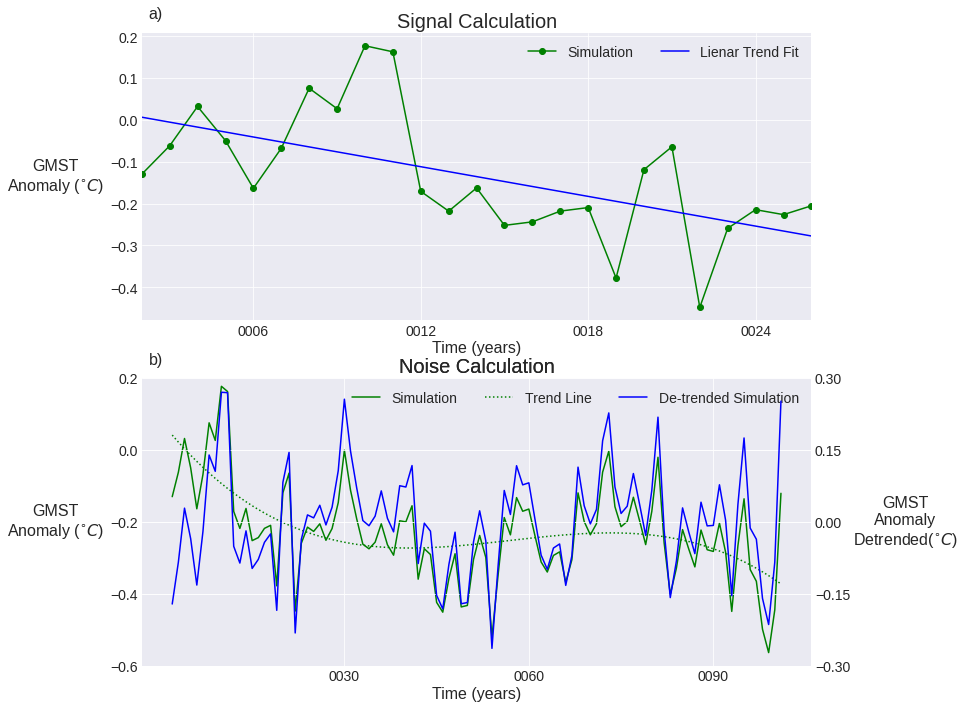

In [24]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(12,18))
axes = [fig.add_subplot(3,1,i) for i in range(1,3)]


# ---> axes[0]
sample_data.plot(ax=axes[0], marker='o', label='Simulation', color='green')
axes[0].plot(sample_data.time.values, fitted_line, label='Lienar Trend Fit', color='blue')
axes[0].set_xlim(sample_data.time.values[0], sample_data.time.values[-1])
axes[0].legend(ncol=2, fontsize=constants.PlotConfig.legend_text_size)

plotting_functions.format_axis(axes[0], title='Signal Calculation', xlabel='Time (years)', ylabel='GMST\n'+r'Anomaly ($^{\circ}C$)', labelpad=55)
plotting_functions.add_figure_label(axes[0], 'a)')

# ---> axes[1]
ax1 = axes[1]; ax2 = axes[1].twinx()
lns1 = experiment_zec_ds_smean_anom.isel(model=model).plot(ax=ax1, color='green', label='Simulation')
lns2 = trend_da.isel(model=model).plot(ax=ax1, label='Trend Line', color='green', linestyle=':')
lns3 = detrended_da.isel(model=model).plot(ax=ax2, label='De-trended Simulation', color='blue')

ytick_locactions = np.arange(-.6, 0.4, 0.2)
ax1.set_yticks(ytick_locactions)
ax1.set_ylim(ytick_locactions[0], ytick_locactions[-1])
ax2_ytick_locations=np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax1.get_yticks()))
ax2.set_yticks(ax2_ytick_locations)

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, ncol=3, loc='best', fontsize=constants.PlotConfig.legend_text_size)

plotting_functions.format_axis(ax1, title='Noise Calculation', xlabel='Time (years)', ylabel='GMST\n'+r'Anomaly ($^{\circ}C$)', labelpad=55)
plotting_functions.format_axis(ax2, title='Noise Calculation', ylabel='GMST\nAnomaly\nDetrended' + r'($^{\circ}C$)', labelpad=55)
plotting_functions.add_figure_label(ax1, 'b)')

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, f'{notebook_number}_method_demonstration.png'),
            bbox_inches='tight', dpi=300)

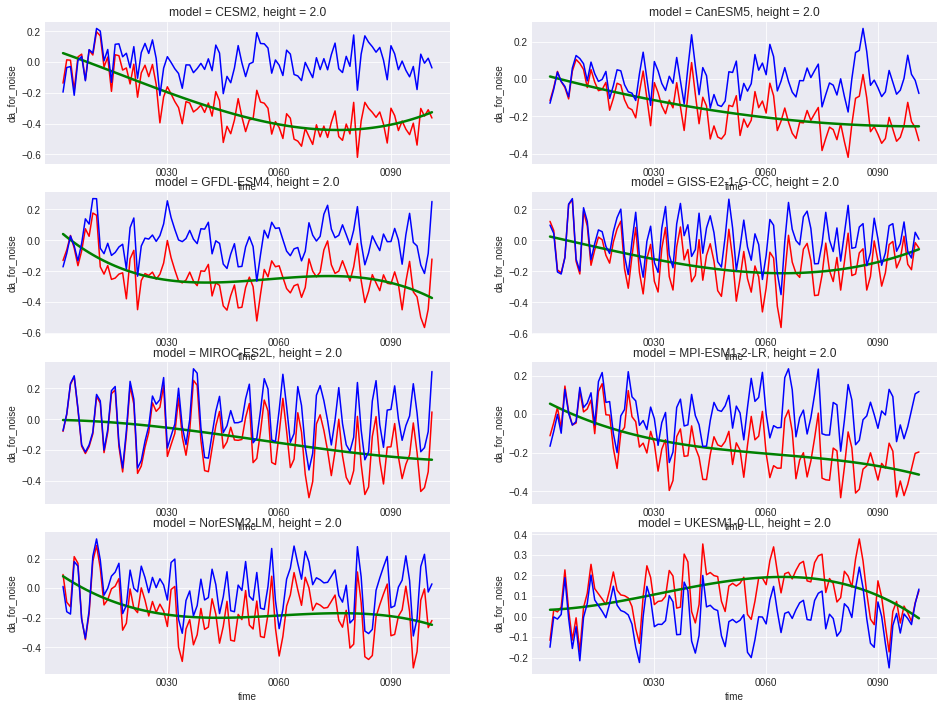

In [25]:
models = experiment_zec_ds_smean.model.values
ncols = 2
nrows = int(np.ceil(len(models)/ncols))

fig = plt.figure(figsize=(8*ncols, 3*nrows))
for plot_num, model in enumerate(models):
    ax = fig.add_subplot(nrows,ncols,plot_num+1)
    experiment_zec_ds_smean_anom.sel(model=model).plot(ax=ax, color='red')
    trend_da.sel(model=model).plot(ax=ax, linewidth=2.5, color='green')
    detrended_da.sel(model=model).plot(ax=ax, color='blue')

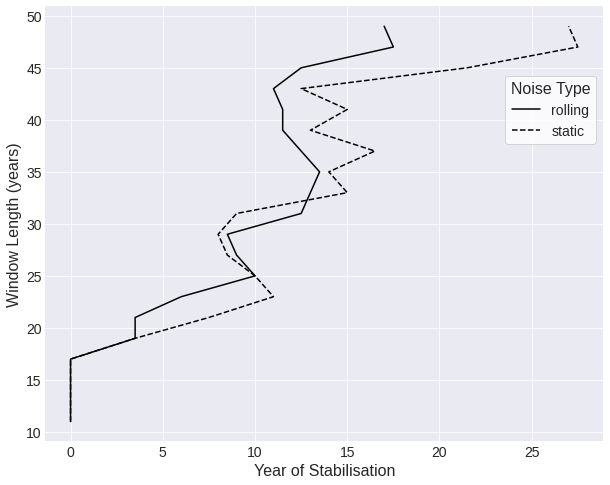

In [26]:
fig, ax = sn_plotting.plot_median_stable_year(static_year_stable, rolling_year_stable)

fig.savefig(os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         f'{notebook_number}_stabilisation_year_double_poly_vs_static.png'),
           dpi=300)

/home/563/ab2313/gdata/images/PhD/top_level/01_global_average_year_of_stabilisation_diff.png


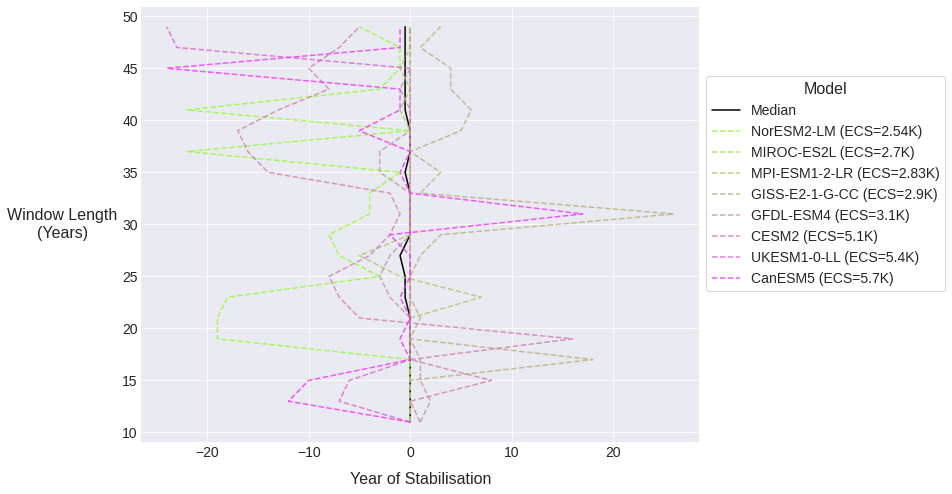

In [27]:
fig, ax = sn_plotting.plot_stable_year_all_models(static_year_stable-rolling_year_stable, exp_type='zecmip')

save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         f'{notebook_number}_global_average_year_of_stabilisation_diff.png')
print(save_name)
fig.savefig(save_name, dpi=300, bbox_inches='tight')

/home/563/ab2313/gdata/images/PhD/top_level/01_global_average_year_of_stabilisation_static.png


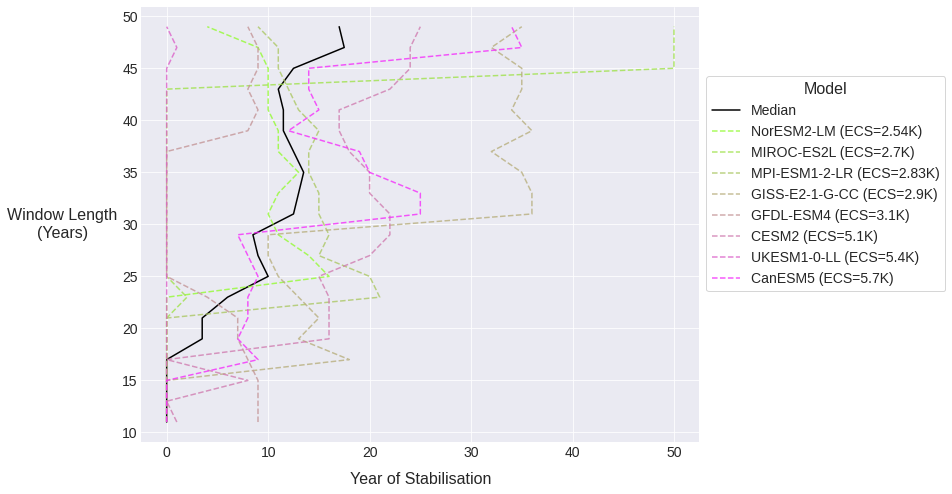

In [28]:
fig, ax = sn_plotting.plot_stable_year_all_models(static_year_stable, exp_type='zecmip')
save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         f'{notebook_number}_global_average_year_of_stabilisation_static.png')
print(save_name)
fig.savefig(save_name, dpi=300, bbox_inches='tight')

/home/563/ab2313/gdata/images/PhD/top_level/01_global_average_year_of_stabilisation_rolling.png


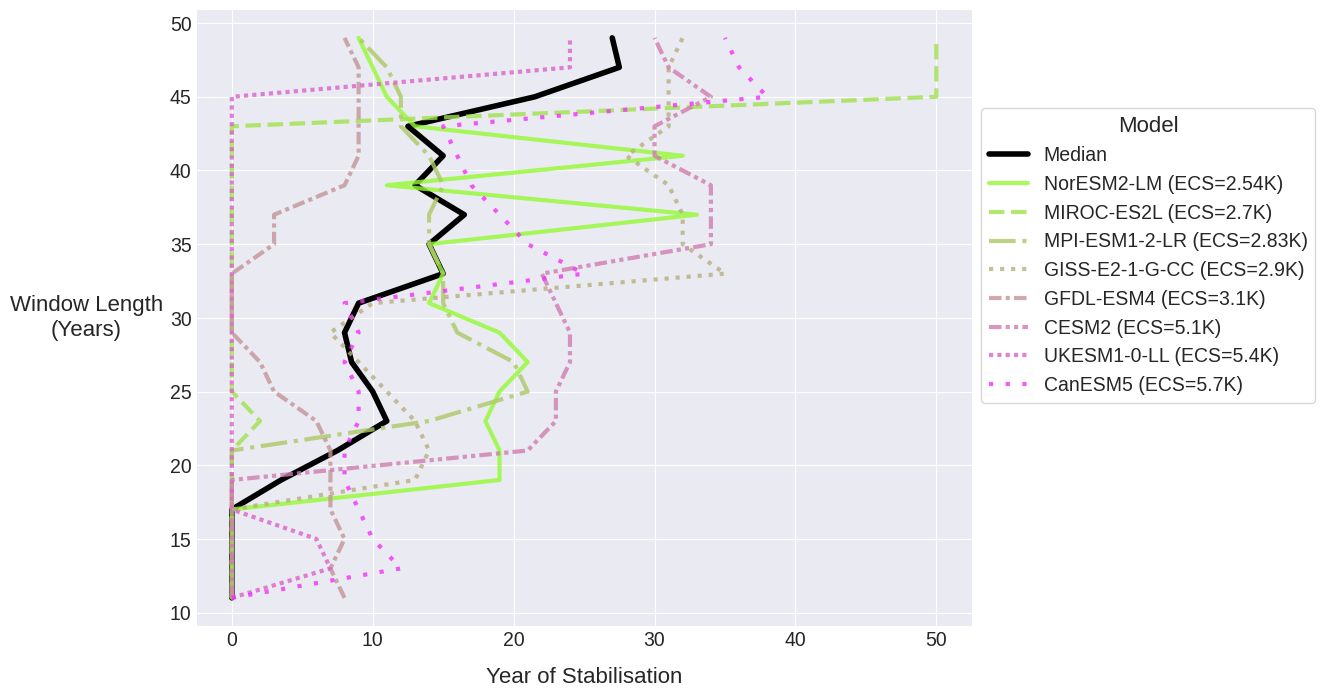

In [92]:
plt.style.use('seaborn-darkgrid')
fig, ax = sn_plotting.plot_stable_year_all_models(rolling_year_stable, exp_type='zecmip')
save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, f'{notebook_number}_global_average_year_of_stabilisation_rolling.png')
print(save_name)
fig.savefig(save_name, dpi=300, bbox_inches='tight')

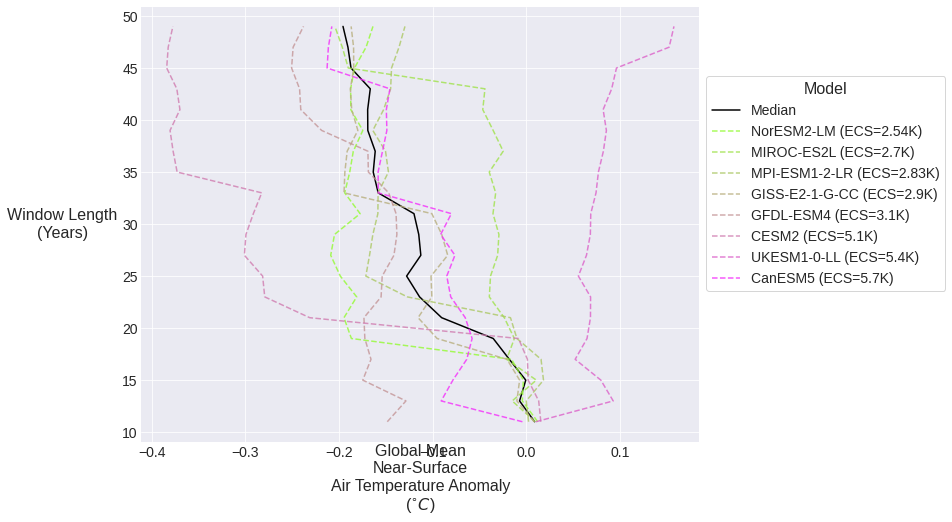

In [30]:
fig, ax = sn_plotting.plot_stable_year_all_models(stable_anom_da.to_dataset(name='time'), exp_type='zecmip', 
                                                 xlabel=f'Global Mean\n{longname} Anomaly\n({units})')

In [73]:
reload(constants)
reload(sn_plotting)
reload(plotting_functions)
reload(constants)

<module 'constants' from '/home/563/ab2313/Documents/PhD/constants.py'>

/home/563/ab2313/gdata/images/PhD/top_level/01_global_average_year_of_stabilisation_and_temp_anomaly.png


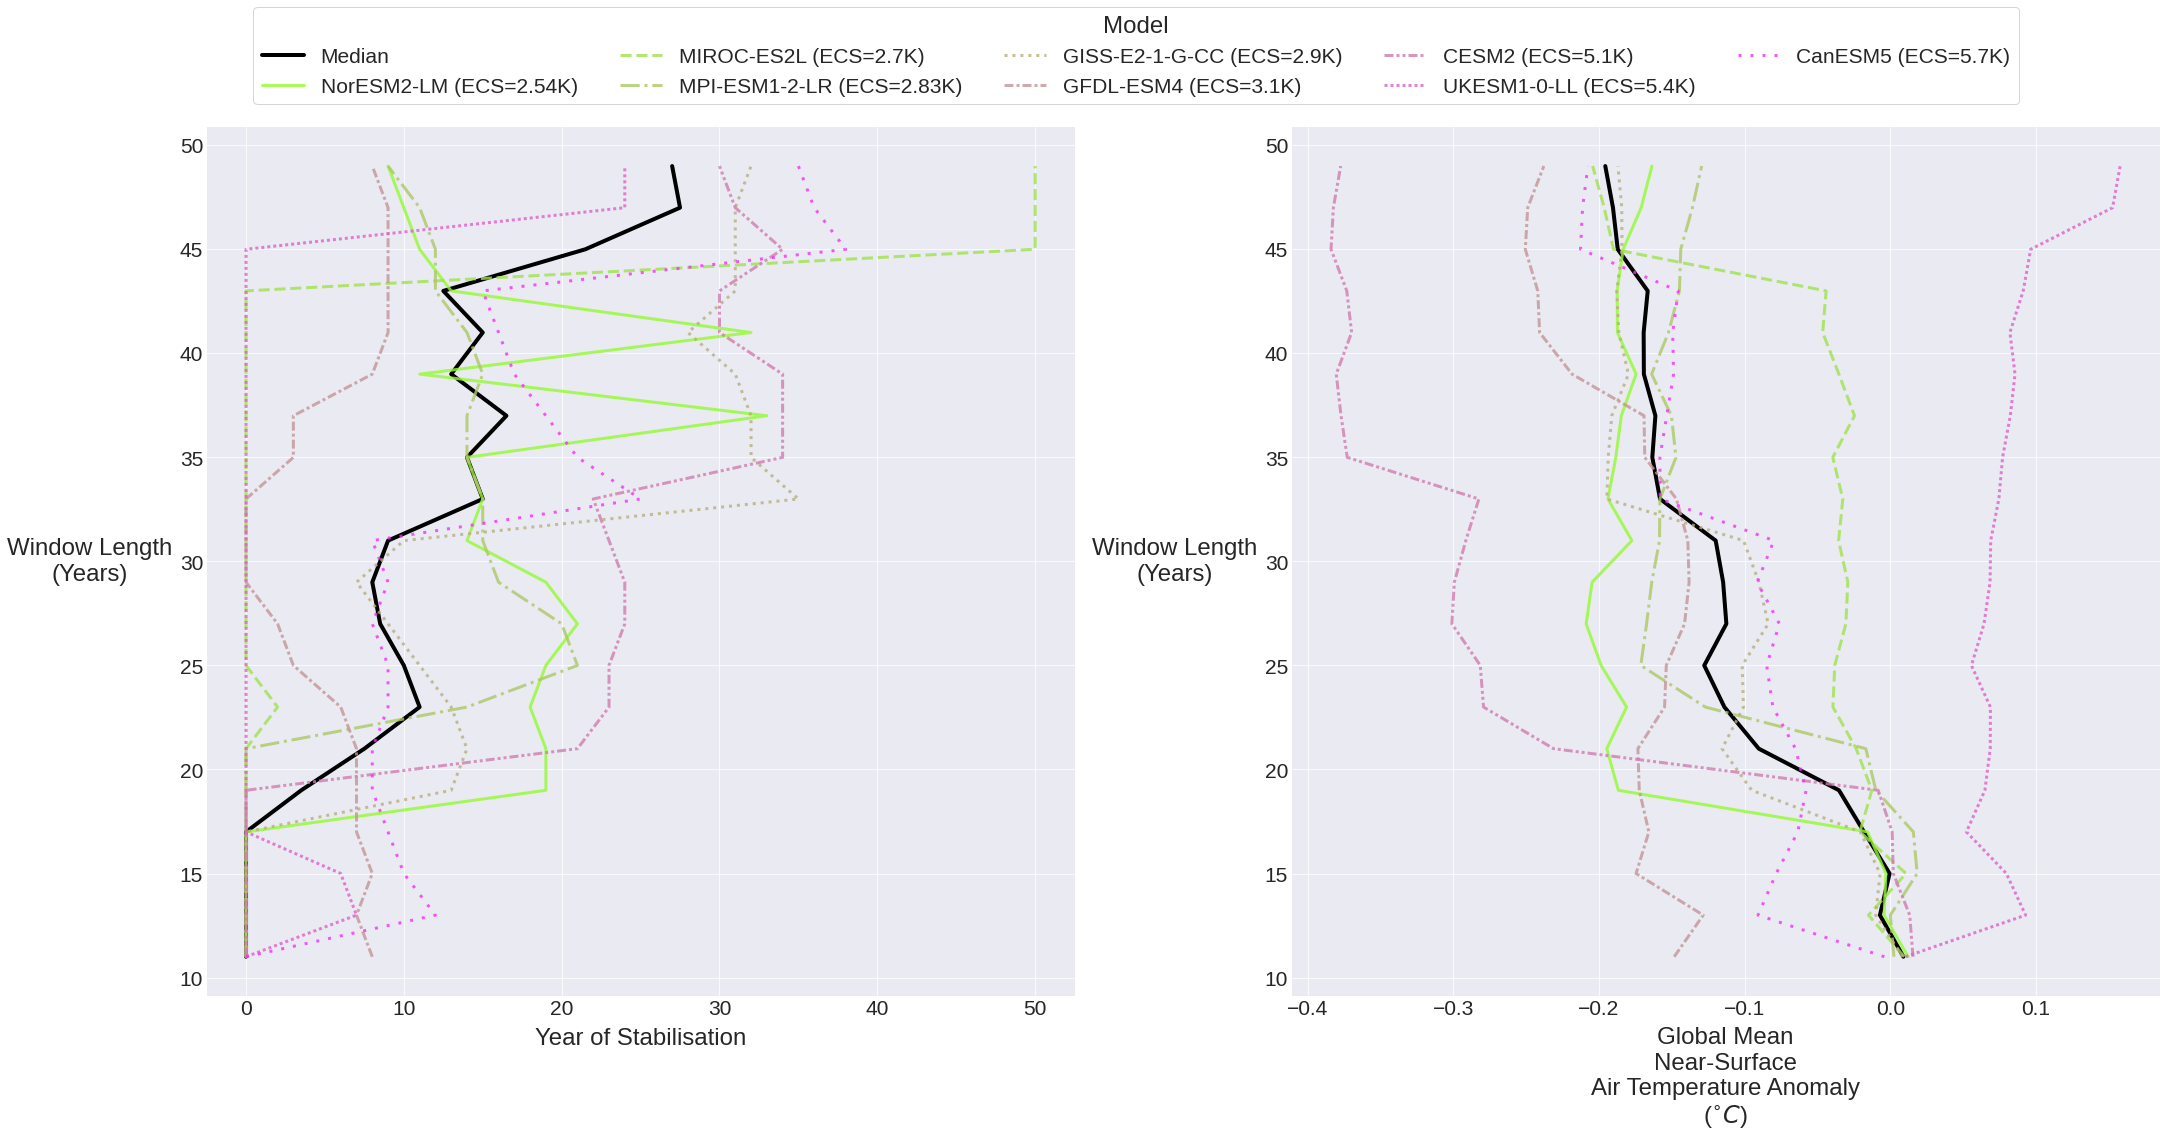

In [75]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize=(35, 16))
gs = gridspec.GridSpec(1,2, wspace=0.25)
ax1 = fig.add_subplot(gs[0]); ax2 = fig.add_subplot(gs[1])
fig, ax = sn_plotting.plot_stable_year_all_models(rolling_year_stable, exp_type='zecmip', ncol=5, 
                                                 fig=fig, ax=ax1, legend_loc = 'top_ofset',
                                                 bbox_to_anchor=(2.1, 1.15), font_scale=1.5)

fig, ax = sn_plotting.plot_stable_year_all_models(
    stable_anom_da.to_dataset(name='time'), fig=fig, ax=ax2, exp_type='zecmip', 
    xlabel=f'Global Mean\n{longname} Anomaly\n({units})',
    add_legend=False, font_scale=1.5, xlabelpad=60)

save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         f'{notebook_number}_global_average_year_of_stabilisation_and_temp_anomaly.png')
print(save_name)
fig.savefig(save_name, dpi=300, bbox_inches='tight')

In [33]:
reload(sn_plotting)

<module 'sn_plotting' from '/home/563/ab2313/Documents/PhD/modules/sn_plotting.py'>

/home/563/ab2313/gdata/images/PhD/top_level/01_global_average_year_of_stabilisation_static_and_rolling.png


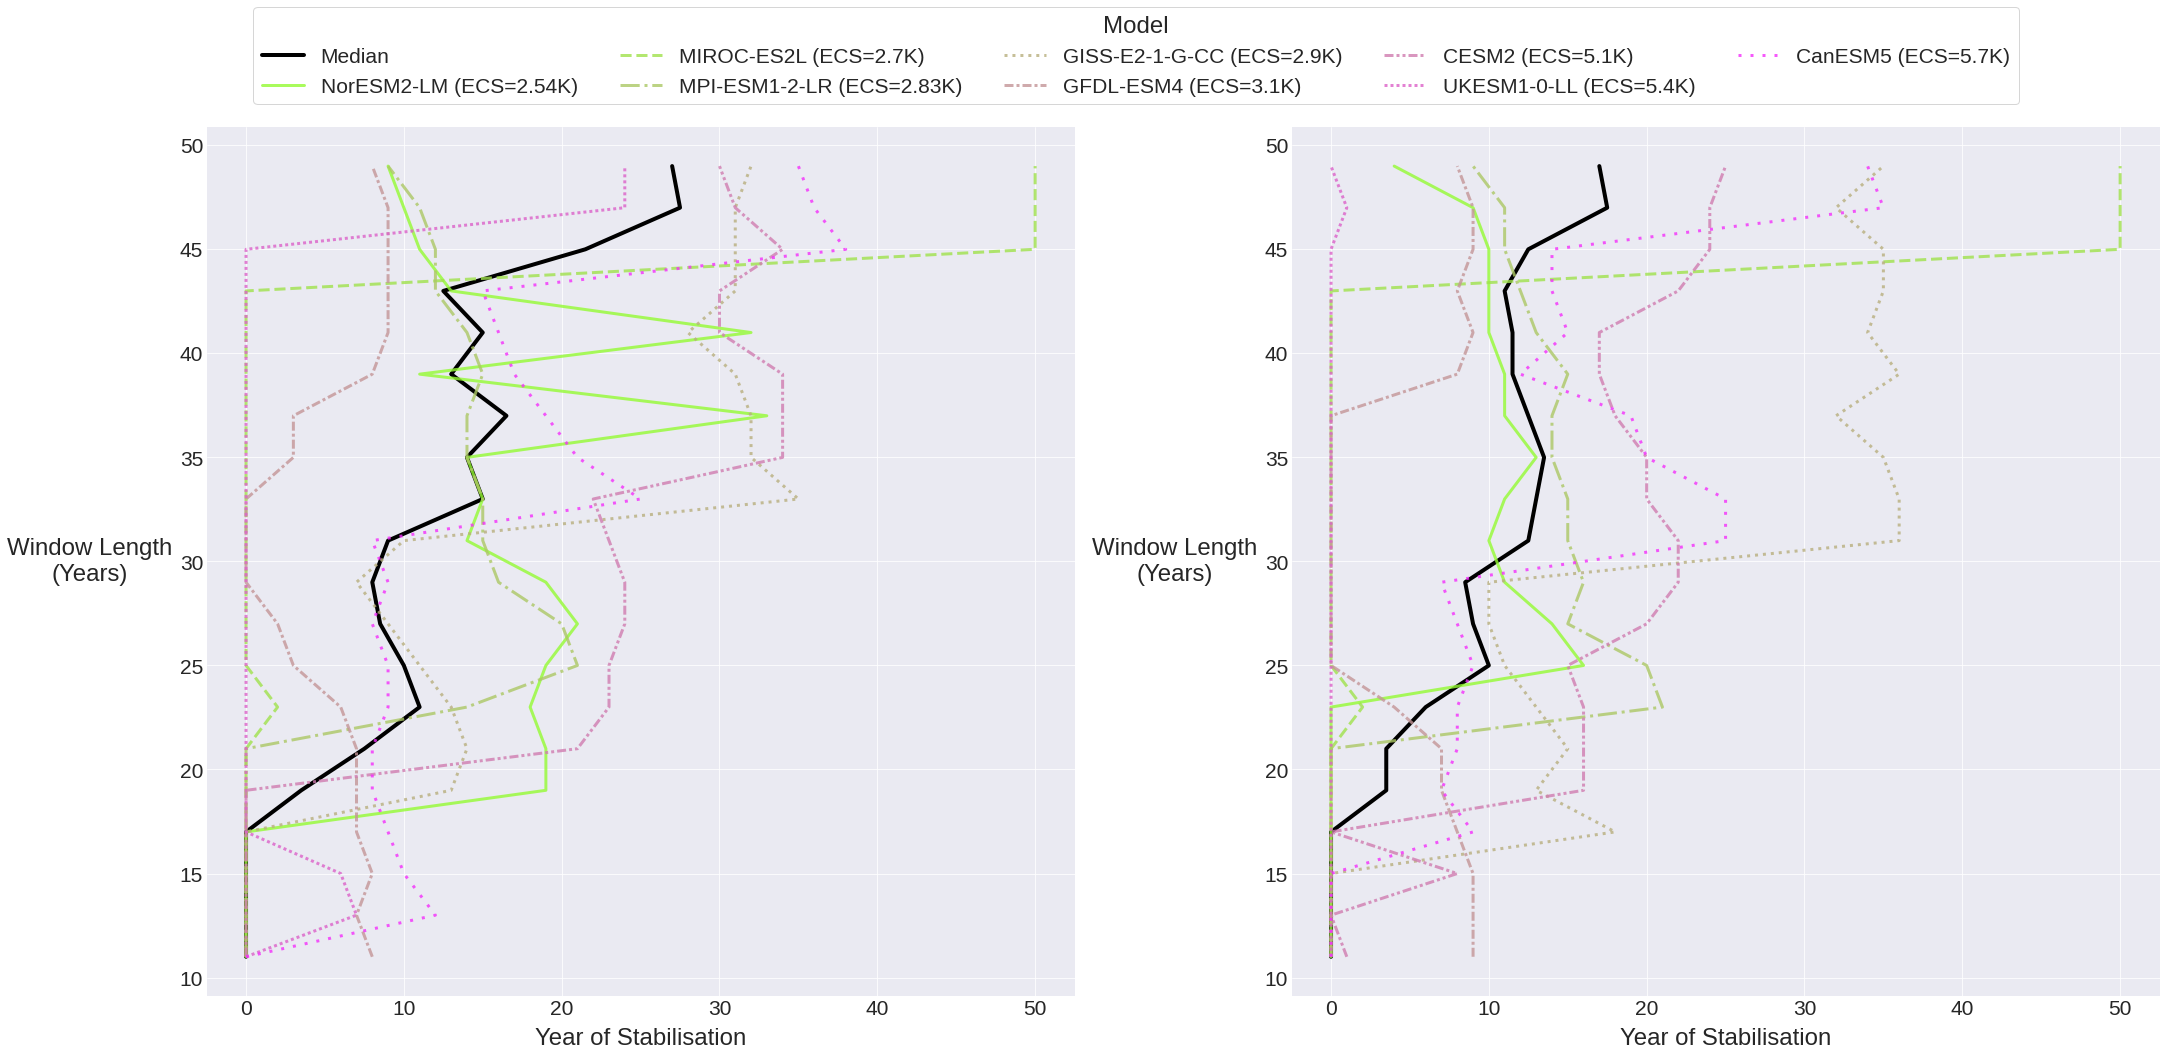

In [76]:
fig = plt.figure(figsize=(35, 16))
gs = gridspec.GridSpec(1,2, wspace=0.25)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
reload(sn_plotting)
fig, ax = sn_plotting.plot_stable_year_all_models(rolling_year_stable, exp_type='zecmip', ncol=5, 
                                                 fig=fig, ax=ax1, legend_loc = 'top_ofset',
                                                 bbox_to_anchor=(2.1, 1.15), font_scale=1.5)
fig, ax = sn_plotting.plot_stable_year_all_models(static_year_stable, exp_type='zecmip', 
                                                 fig=fig, ax=ax2, add_legend=False, font_scale=1.5)
save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         f'{notebook_number}_global_average_year_of_stabilisation_static_and_rolling.png')
print(save_name)
fig.savefig(save_name, dpi=300, bbox_inches='tight')

/home/563/ab2313/gdata/images/PhD/top_level/01_global_average_picontrol_time_series.png


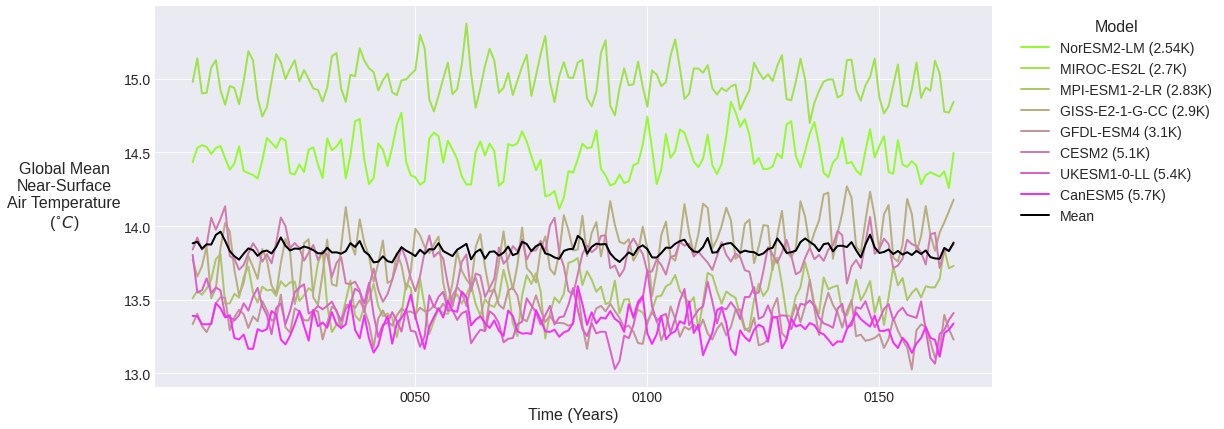

In [35]:
plt.style.use('seaborn-darkgrid')
fig, ax = sn_plotting.plot_all_coord_lines(picontrol_zec_ds_smean-273.14, exp_type='zecmip', xlabel='Time (Years)',
                              ylabel=f'Global Mean\n{longname}\n({units})', ncol=1)
save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL, f'{notebook_number}_global_average_picontrol_time_series.png'); print(save_name)
fig.savefig(save_name, dpi=300, bbox_inches='tight')

/home/563/ab2313/gdata/images/PhD/top_level/01_global_average_A1_time_series.png


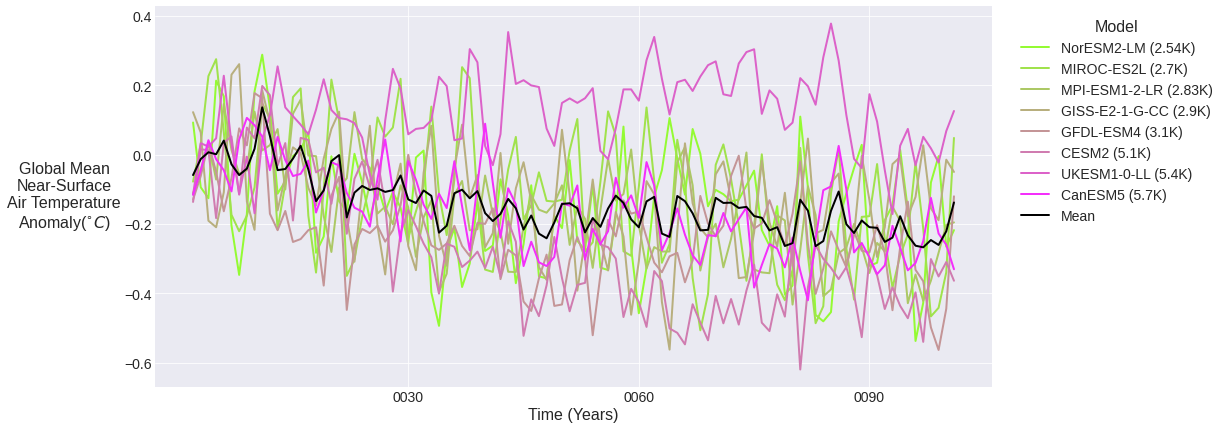

In [36]:
plt.style.use('seaborn-darkgrid')
fig, ax = sn_plotting.plot_all_coord_lines(experiment_zec_ds_smean_anom, exp_type='zecmip',
                               xlabel='Time (Years)', ylabel=f'Global Mean\n{longname}\nAnomaly({units})', ncol=1)
save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         f'{notebook_number}_global_average_A1_time_series.png')
print(save_name)
fig.savefig(save_name, dpi=300, bbox_inches='tight')

In [37]:
models = rolling_year_stable.model.values
levels = np.arange(0, len(models)+1,1)
my_blues = plotting_functions.create_discrete_cmap('Blues', levels=levels, add_white=True)
my_reds = plotting_functions.create_discrete_cmap('Reds', levels=levels, add_white=True)

plot_kwargs = dict(exp_type='zecmip',vmin=0, vmax=len(models)+1, step=1, tick_offset='center',
                   extend='neither', cbar_label='Number of Unstable Models')

comparison_kwargs = dict(max_color_lim=50, xlims=(0,50), font_scale=1.6)

/home/563/ab2313/gdata/images/PhD/top_level/01_global_average_stabilisation_pattern_comparison_static_and_rolling.png


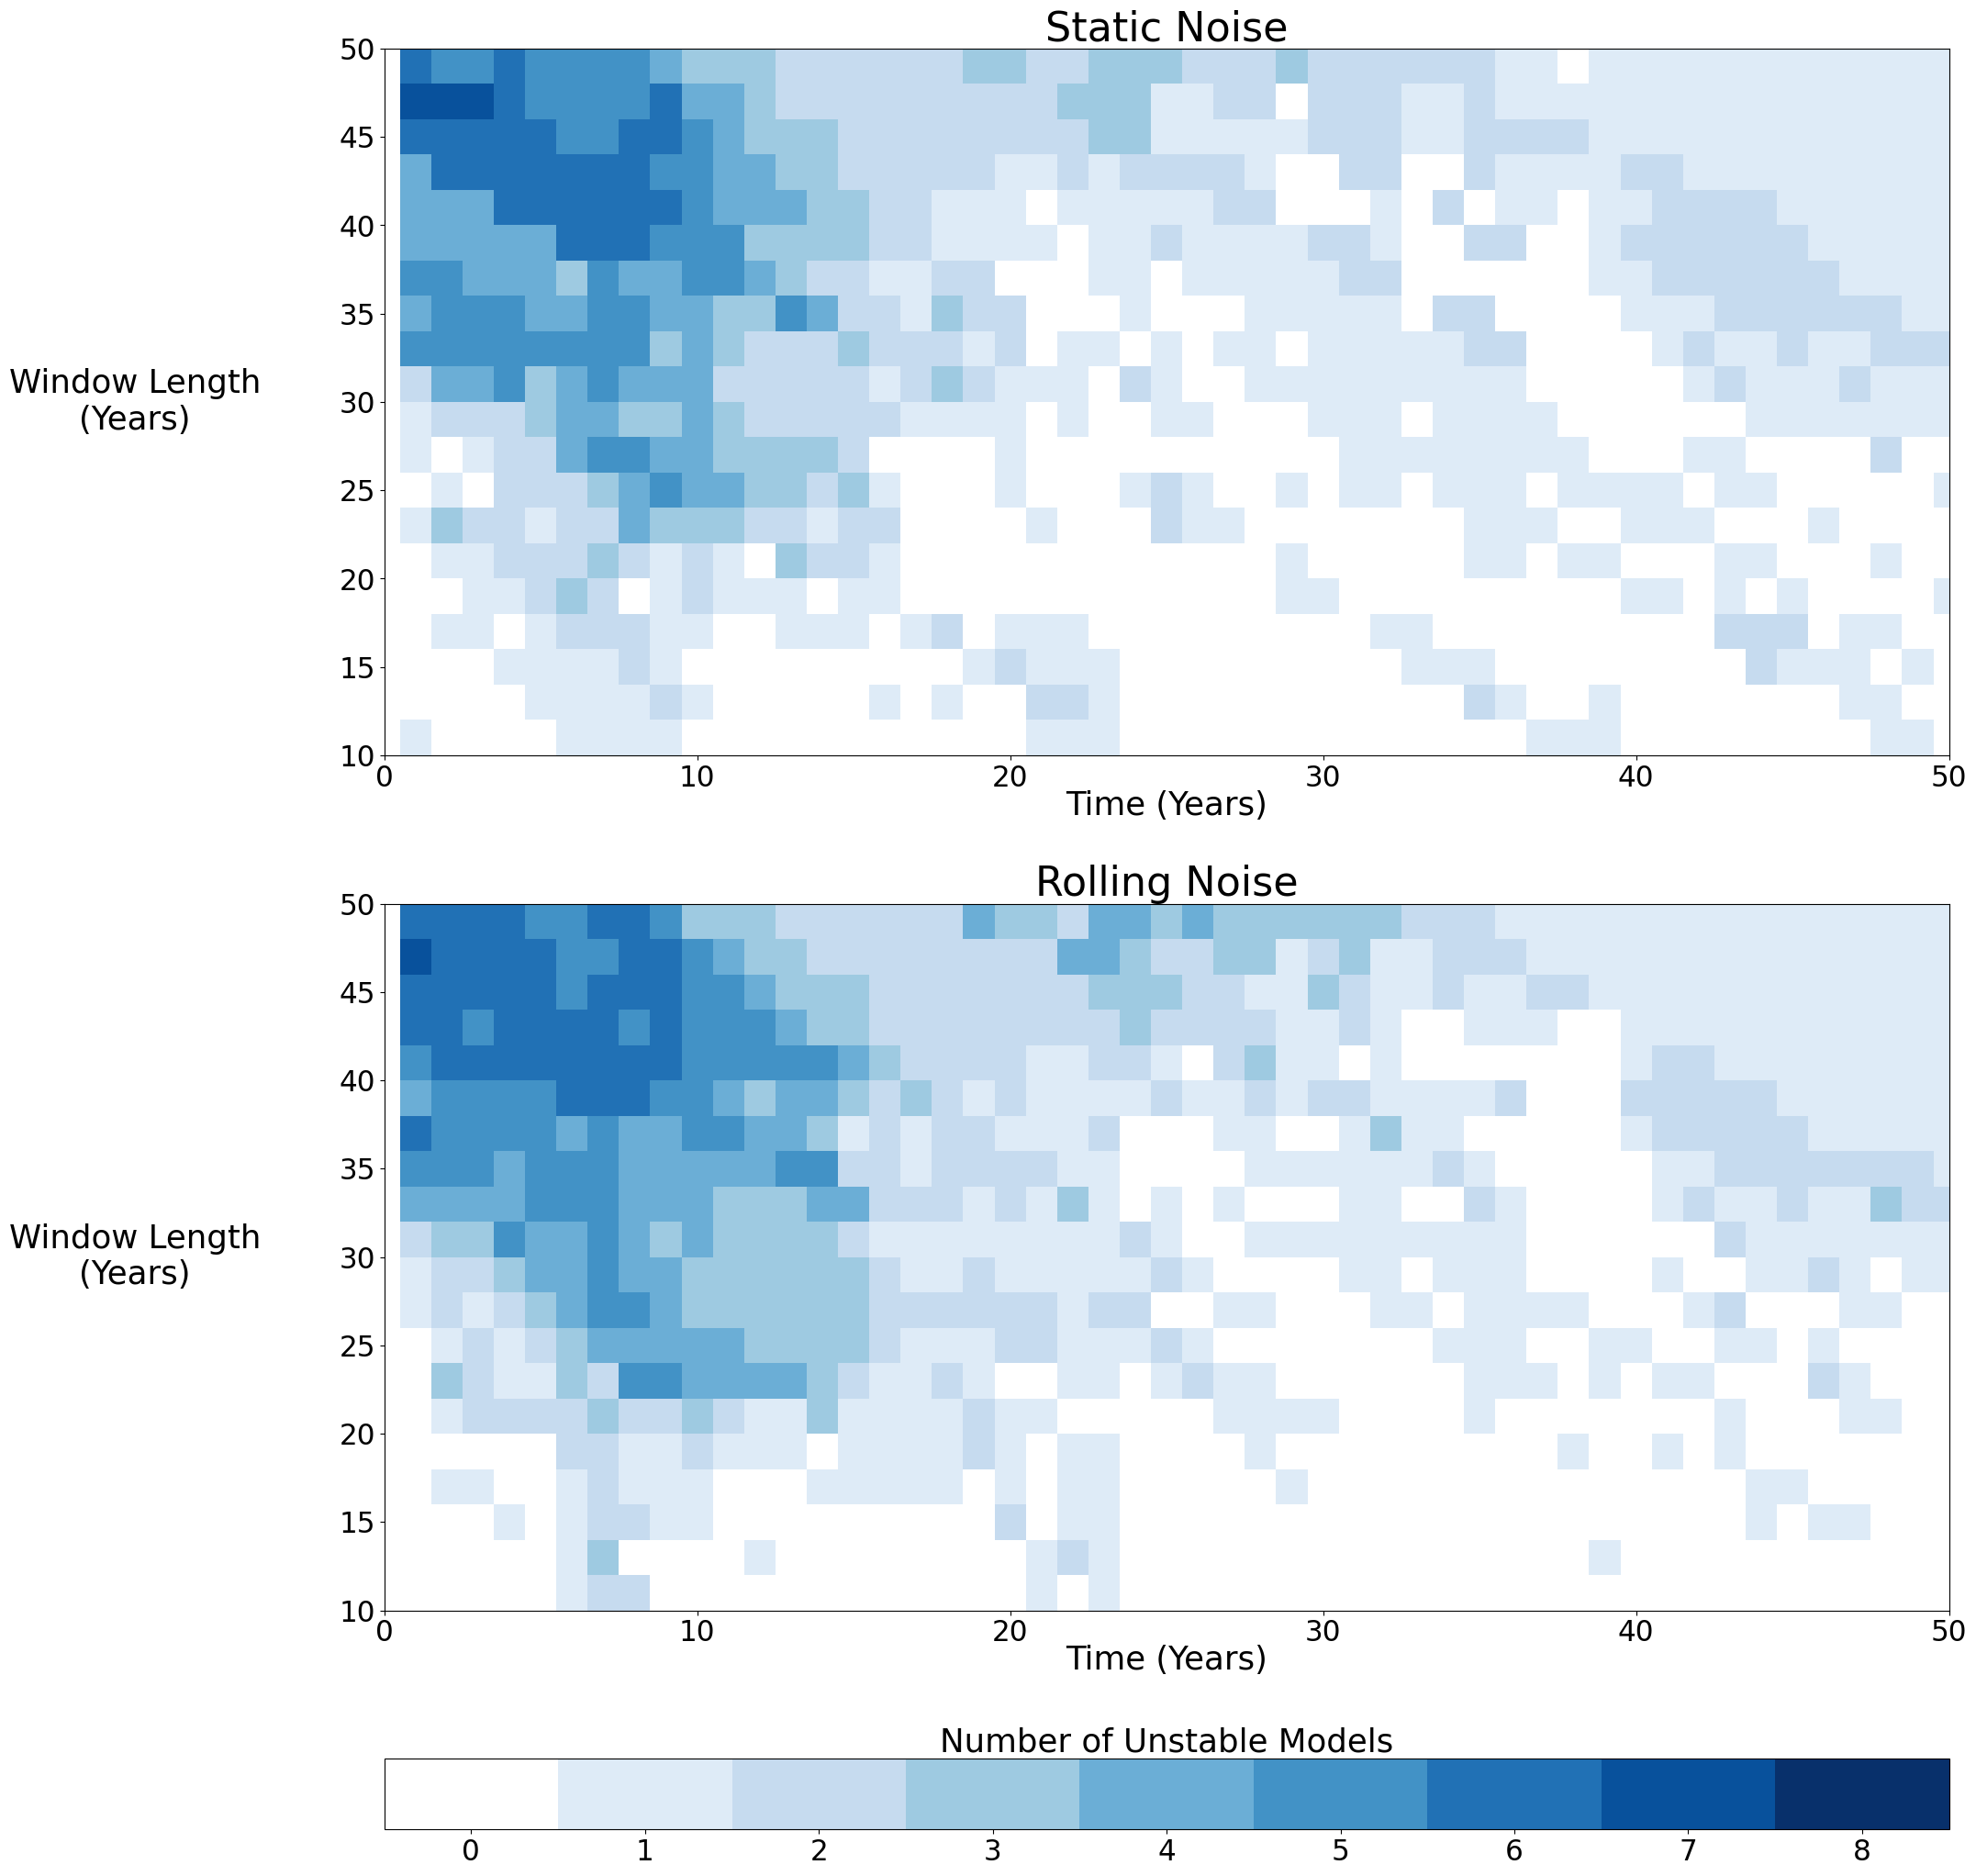

In [38]:
mpl.rcParams.update(mpl.rcParamsDefault)

fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width'],
                          sn_plotting.plot_kwargs['height']*2.1))

gs = gridspec.GridSpec(3,1, height_ratios=[1, 1, 0.1], hspace=sn_plotting.plot_kwargs['hspace'])
axes = [fig.add_subplot(gs[i]) for i in range(3)]

sn_plotting.sn_multi_window_in_time(
    static_stability_levels_ds.sel(stability='unstable').count(dim='model'), cmap=my_blues,
    fig=fig, gs=gs, ax=axes[0], add_colorbar=False, return_all=False, axes_title='Static Noise',
    **plot_kwargs, **comparison_kwargs)

sn_plotting.sn_multi_window_in_time(
    rolling_stability_levels_ds.sel(stability='unstable').count(dim='model'), cmap=my_blues,
    fig=fig, gs=gs, ax=axes[1], cax=axes[2], return_all=False, axes_title='Rolling Noise',
    **plot_kwargs, **comparison_kwargs)


save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
   f'{notebook_number}_global_average_stabilisation_pattern_comparison_static_and_rolling.png')
print(save_name)
fig.savefig(save_name, dpi=300, bbox_inches='tight')

In [39]:
reload(sn_plotting)
reload(plotting_functions)
%matplotlib inline

In [40]:
stability_colorplot_kwargs = dict(max_color_lim=50, xlims=(0, 90),patch=True, ax2_ylabel=f'GMST Anomaly({units})')

/home/563/ab2313/gdata/images/PhD/top_level/01_global_all_model_sn_pattern.png


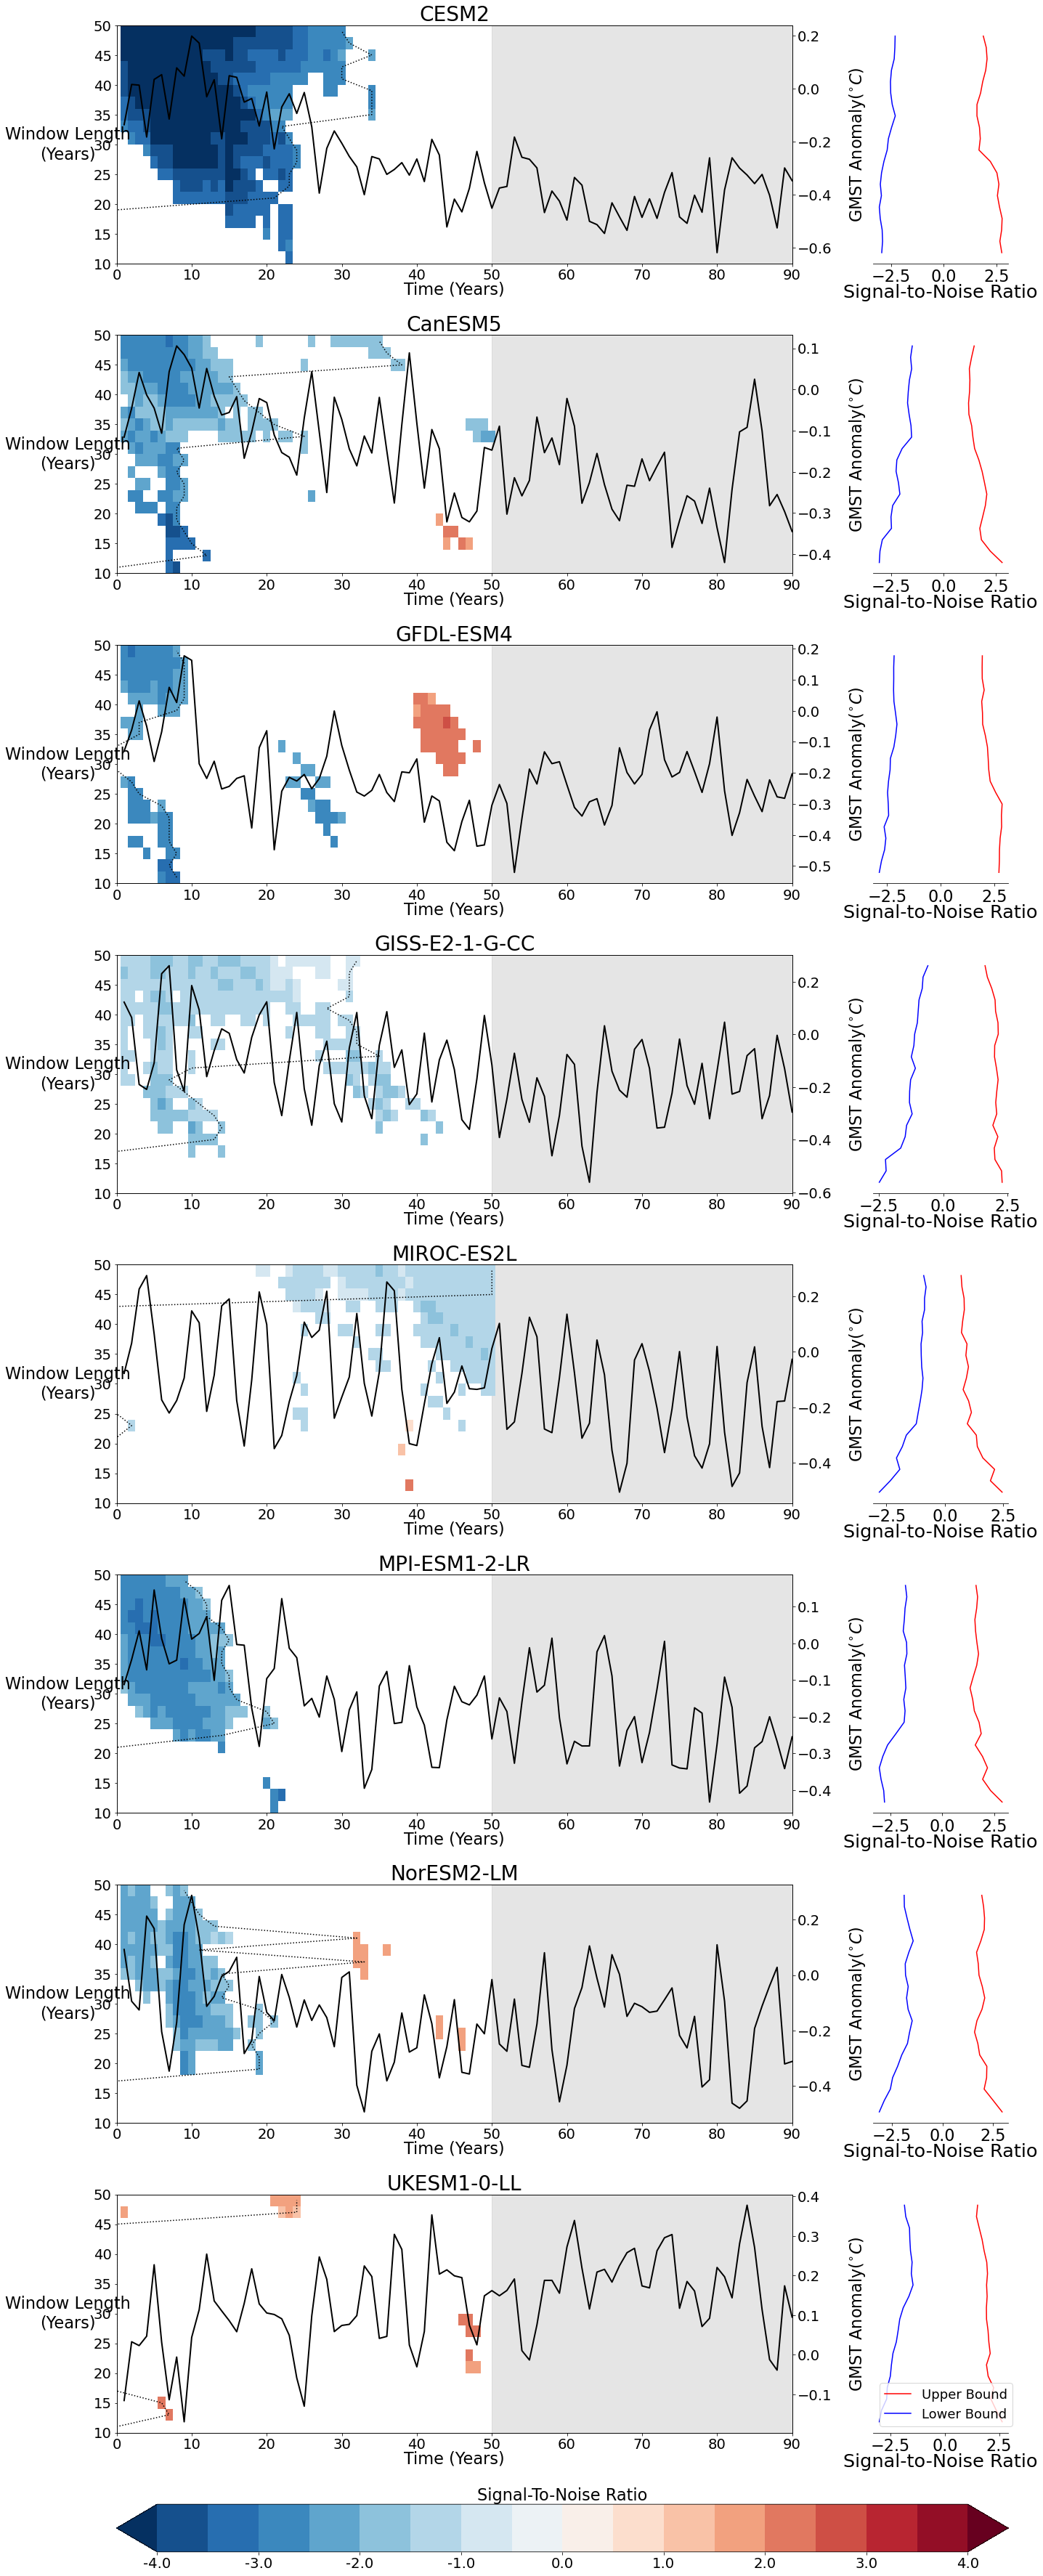

In [41]:
%matplotlib inline
models = unstable_rolling.model.values
sn_levels = np.arange(-4.5, 4.5+.5, 0.5)

fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width'], 
                          sn_plotting.plot_kwargs['height']*len(models)/1.5))
gs = gridspec.GridSpec(len(models)+1, 2, height_ratios=len(models)*[1] + [0.2], width_ratios=[1, 0.2],
                       hspace=sn_plotting.plot_kwargs['hspace']*1.1)
axes_left = [fig.add_subplot(gs[i, 0]) for i in range(len(models))]
axes_right = [fig.add_subplot(gs[i, 1]) for i in range(len(models))]

for num, model in enumerate(models):
    add_colorbar=False; cax=None
    if num == len(models)-1: add_colorbar=True; cax=fig.add_subplot(gs[num+1, :])
    sn_plotting.sn_multi_window_in_time(
        unstable_rolling.sel(model=model).signal_to_noise, cmap='RdBu_r',
        fig=fig, gs=gs, ax=axes_left[num], cax=cax, add_colorbar=add_colorbar,
        axes_title=model, bbox_to_anchor=(1, 1.4),
        temp_da=experiment_zec_ds_smean_anom.sel(model=model),
        stable_point_ds = rolling_year_stable.sel(model=model), labelpad=25,
        extend='both', cut_ticks=2, vmax=4, step=0.5,  font_scale=1.4, cbar_label='Signal-To-Noise Ratio',
        hspace=0.2, return_all=False, **stability_colorplot_kwargs, rotation=90)  
    
    sn_multi_rolling_ds.sel(model=model).upper_bound.plot(ax=axes_right[num], y='window', color='red',
                                                         label='Upper Bound')
    sn_multi_rolling_ds.sel(model=model).lower_bound.plot(ax=axes_right[num], y='window', color='blue',
                                                         label='Lower Bound')
    plotting_functions.format_axis(axes_right[num], xlabel='Signal-to-Noise Ratio', ylabel='',
                                  title='', font_scale=1.6)
    [axes_right[num].spines[sp].set_visible(False) for sp in ['top', 'left', 'right']]
    axes_right[num].set_yticks([])
    axes_right[num].set_yticklabels([])
    axes_right[num].set_title('')
    axes_right[num].set_ylabel('')
    if num == len(models)-1:axes_right[num].legend(ncol=1, fontsize=18)
    
for num, ax in enumerate(axes): plotting_functions.add_figure_label(ax, f'{chr(97+num)})', font_scale=1.4)
    
save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         f'{notebook_number}_global_all_model_sn_pattern.png')
print(save_name)
fig.savefig(save_name, dpi=300, bbox_inches='tight')

In [86]:
stability_colorplot_kwargs2 = dict(xlims=(0, 50),patch=False, ax2_ylabel=f'GMST Anomaly({units})')

/home/563/ab2313/gdata/images/PhD/top_level/01_global_average_stabilisation_pattern_rolling_no_gmst_anom.png


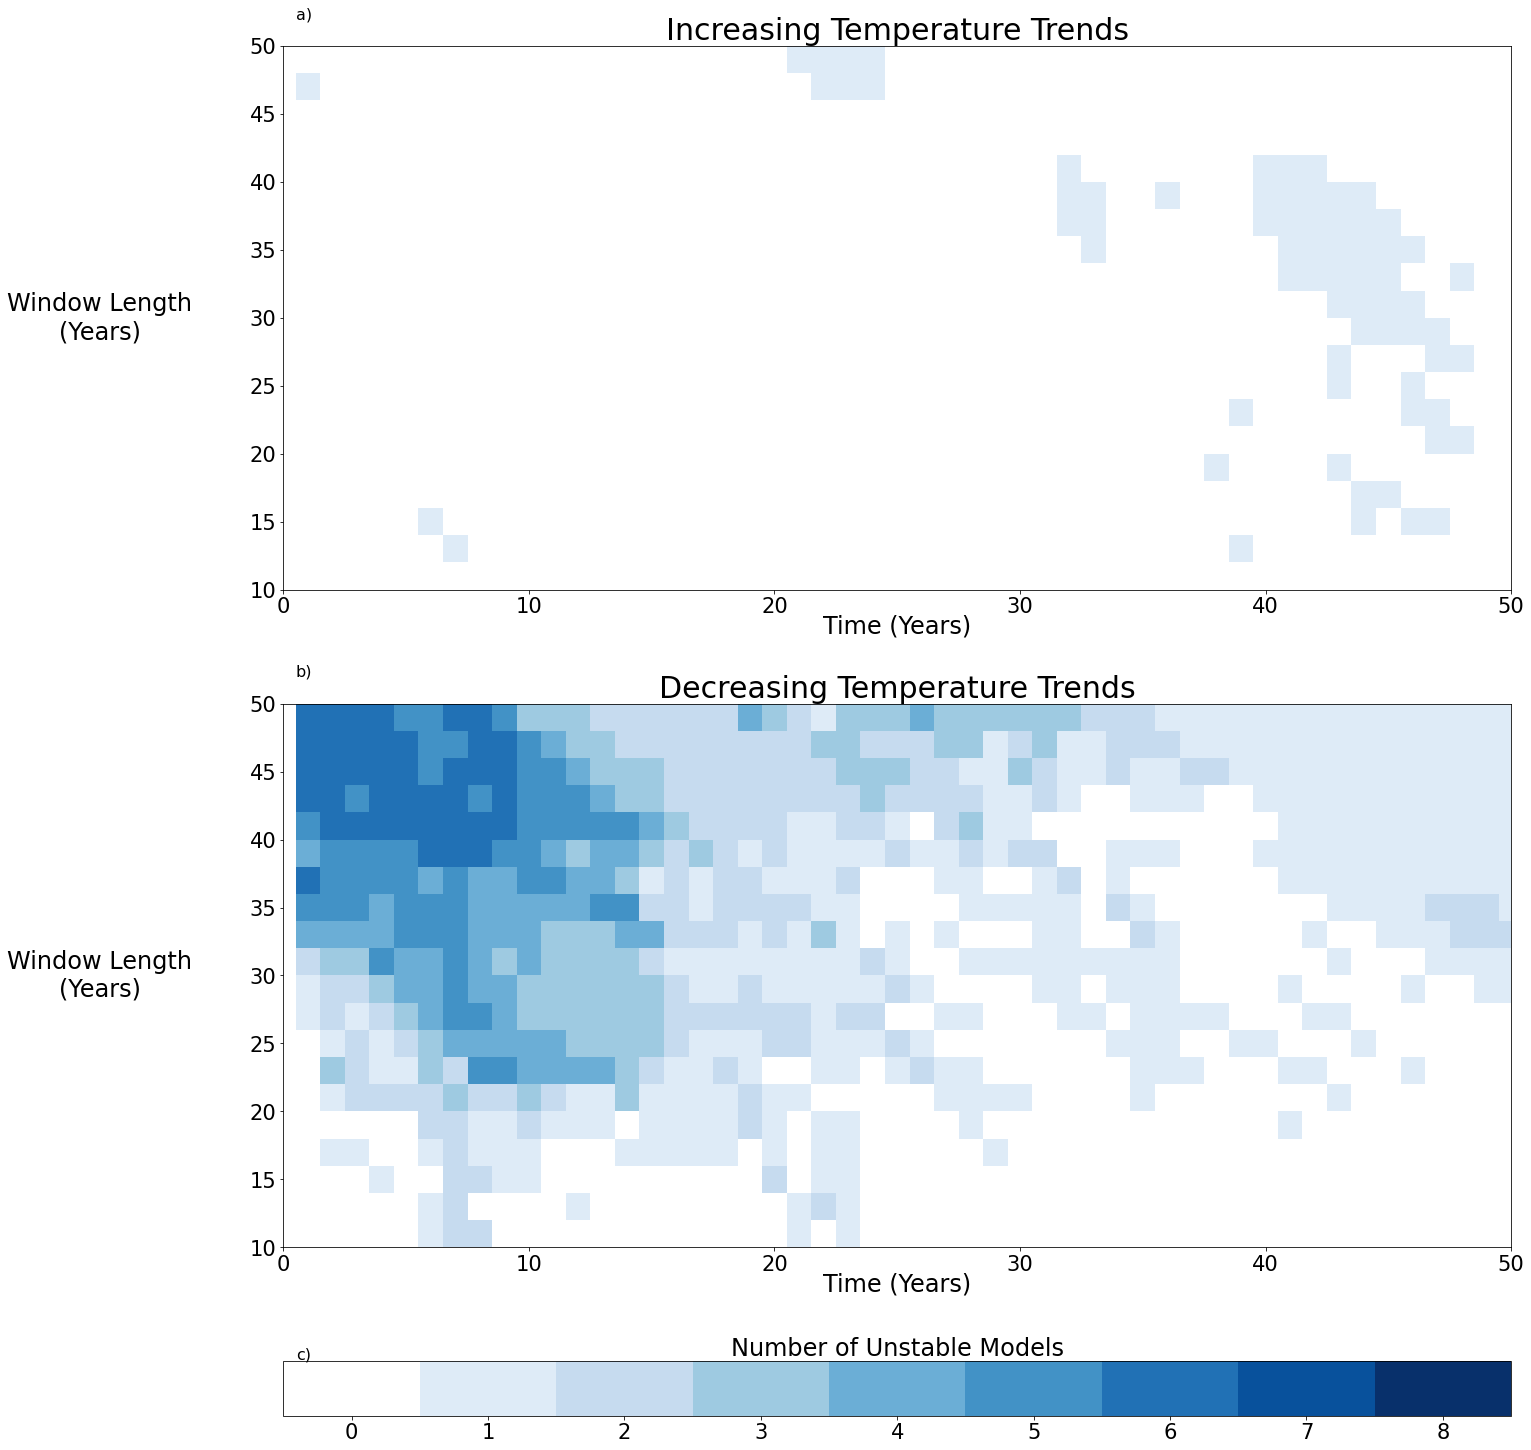

In [88]:
%matplotlib inline
fig = plt.figure(figsize=(sn_plotting.plot_kwargs['width'], sn_plotting.plot_kwargs['height']*2.1))

gs = gridspec.GridSpec(3,1, height_ratios=[1, 1, 0.1], hspace=sn_plotting.plot_kwargs['hspace'])
axes = [fig.add_subplot(gs[i]) for i in range(3)]

sn_plotting.sn_multi_window_in_time(
    rolling_stability_levels_ds.sel(stability='increasing').count(dim='model'), cmap=my_blues,
    fig=fig, gs=gs, ax=axes[0], add_colorbar=False, return_all=False,
    axes_title='Increasing Temperature Trends', bbox_to_anchor=(1, 1.4),
    # temp_da=experiment_zec_ds_smean_anom, **stability_colorplot_kwargs
    **stability_colorplot_kwargs2,  **plot_kwargs)

sn_plotting.sn_multi_window_in_time(
    rolling_stability_levels_ds.sel(stability='decreasing').count(dim='model'), cmap=my_blues,
    fig=fig, gs=gs, ax=axes[1], cax=axes[2], return_all=False,
    axes_title='Decreasing Temperature Trends',
    add_legend=False,
    # temp_da=experiment_zec_ds_smean_anom, **stability_colorplot_kwargs
    **stability_colorplot_kwargs2,  **plot_kwargs)


for num, ax_ in enumerate(axes):
    plotting_functions.add_figure_label(ax_, f'{chr(97+num)})')

save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         f'{notebook_number}_global_average_stabilisation_pattern_rolling_no_gmst_anom.png')
print(save_name)
fig.savefig(save_name, dpi=300, bbox_inches='tight')

In [43]:
%matplotlib inline

/home/563/ab2313/gdata/images/PhD/top_level/01_global_average_stabilisation_pattern_warming_static.png


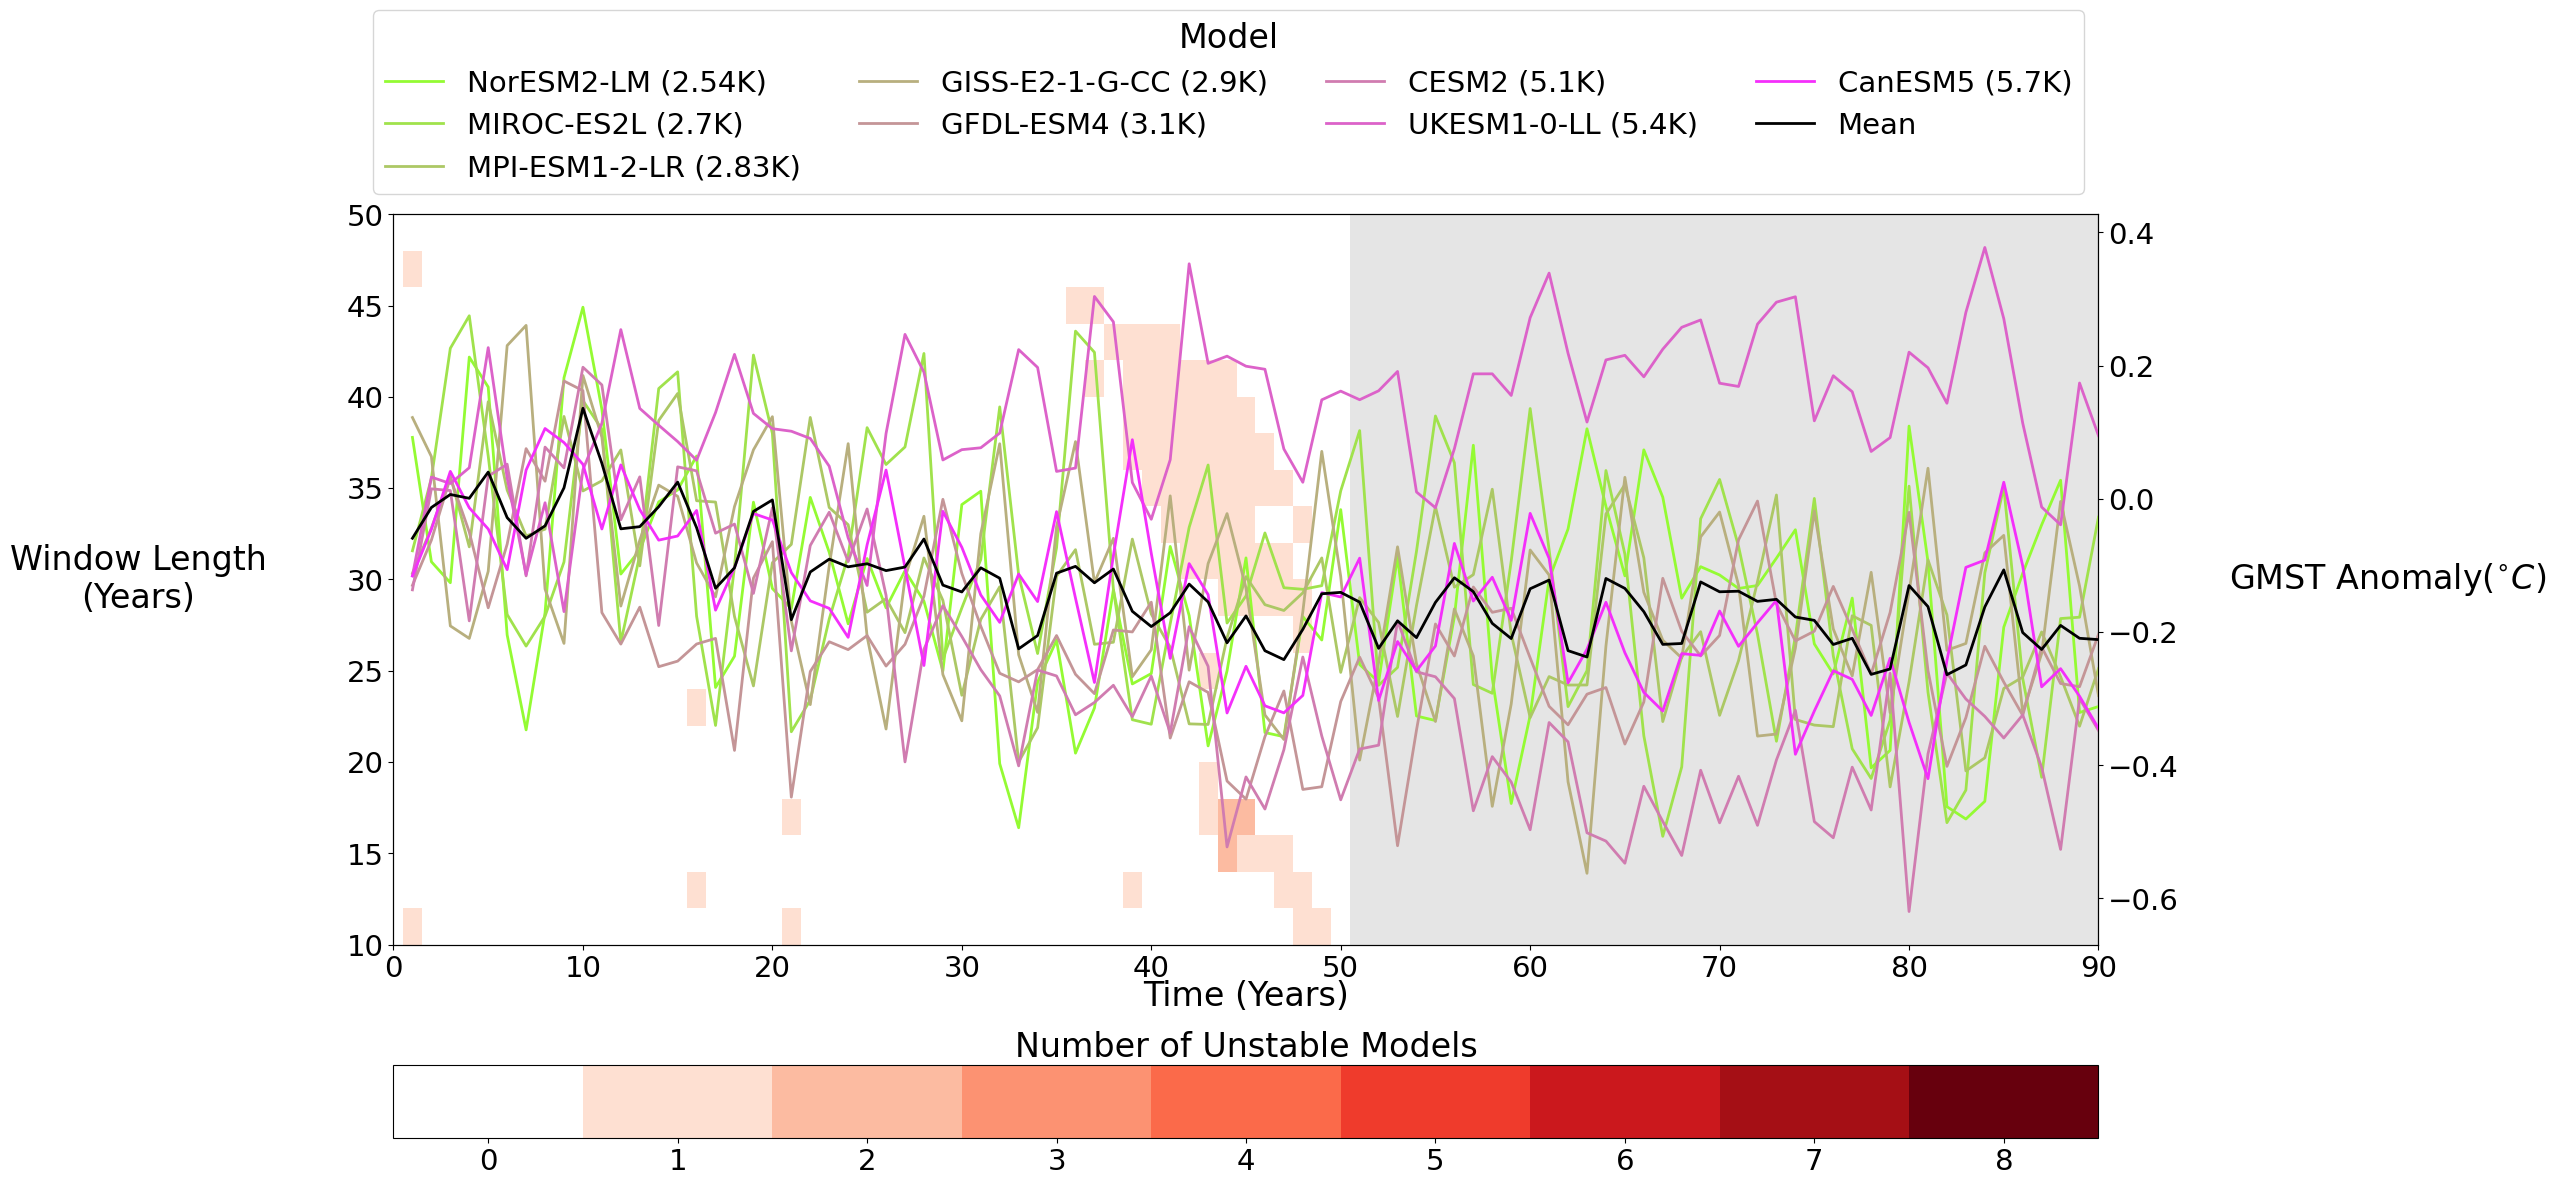

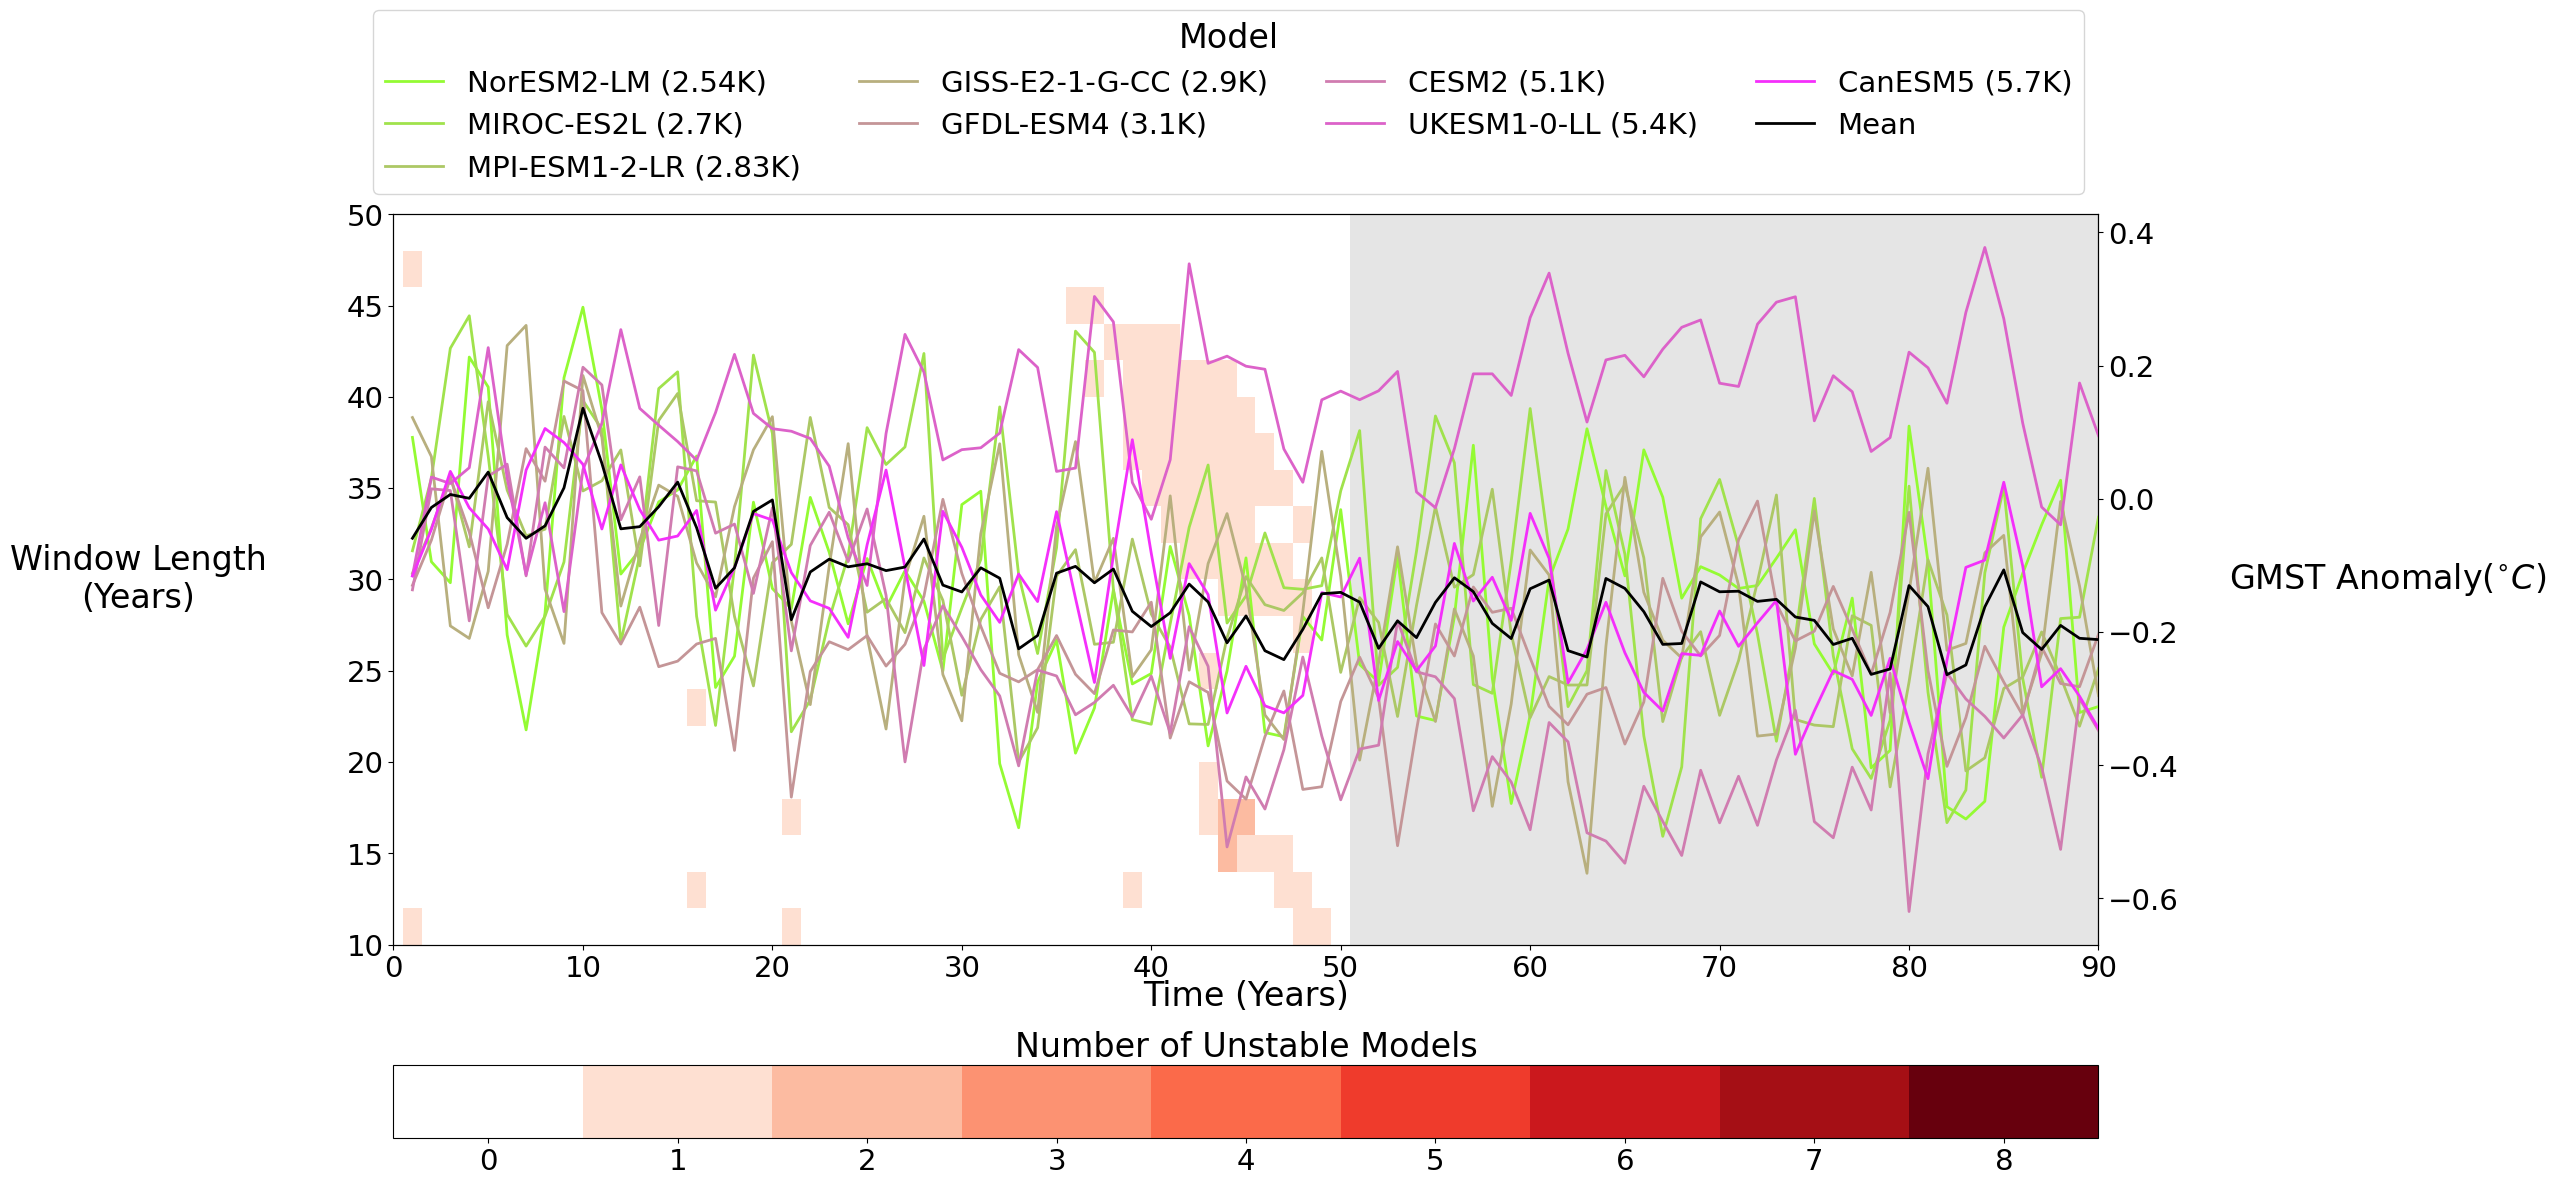

In [44]:
fig, axes = sn_plotting.sn_multi_window_in_time(
    static_stability_levels_ds.sel(stability='increasing').count(dim='model'),
    temp_da=experiment_zec_ds_smean_anom, cmap=my_reds, **stability_colorplot_kwargs,  **plot_kwargs)
fig

save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         f'{notebook_number}_global_average_stabilisation_pattern_warming_static.png')
print(save_name)
fig.savefig(save_name, dpi=300, bbox_inches='tight')
fig

/home/563/ab2313/gdata/images/PhD/top_level/01_global_average_stabilisation_pattern_cooling_static.png


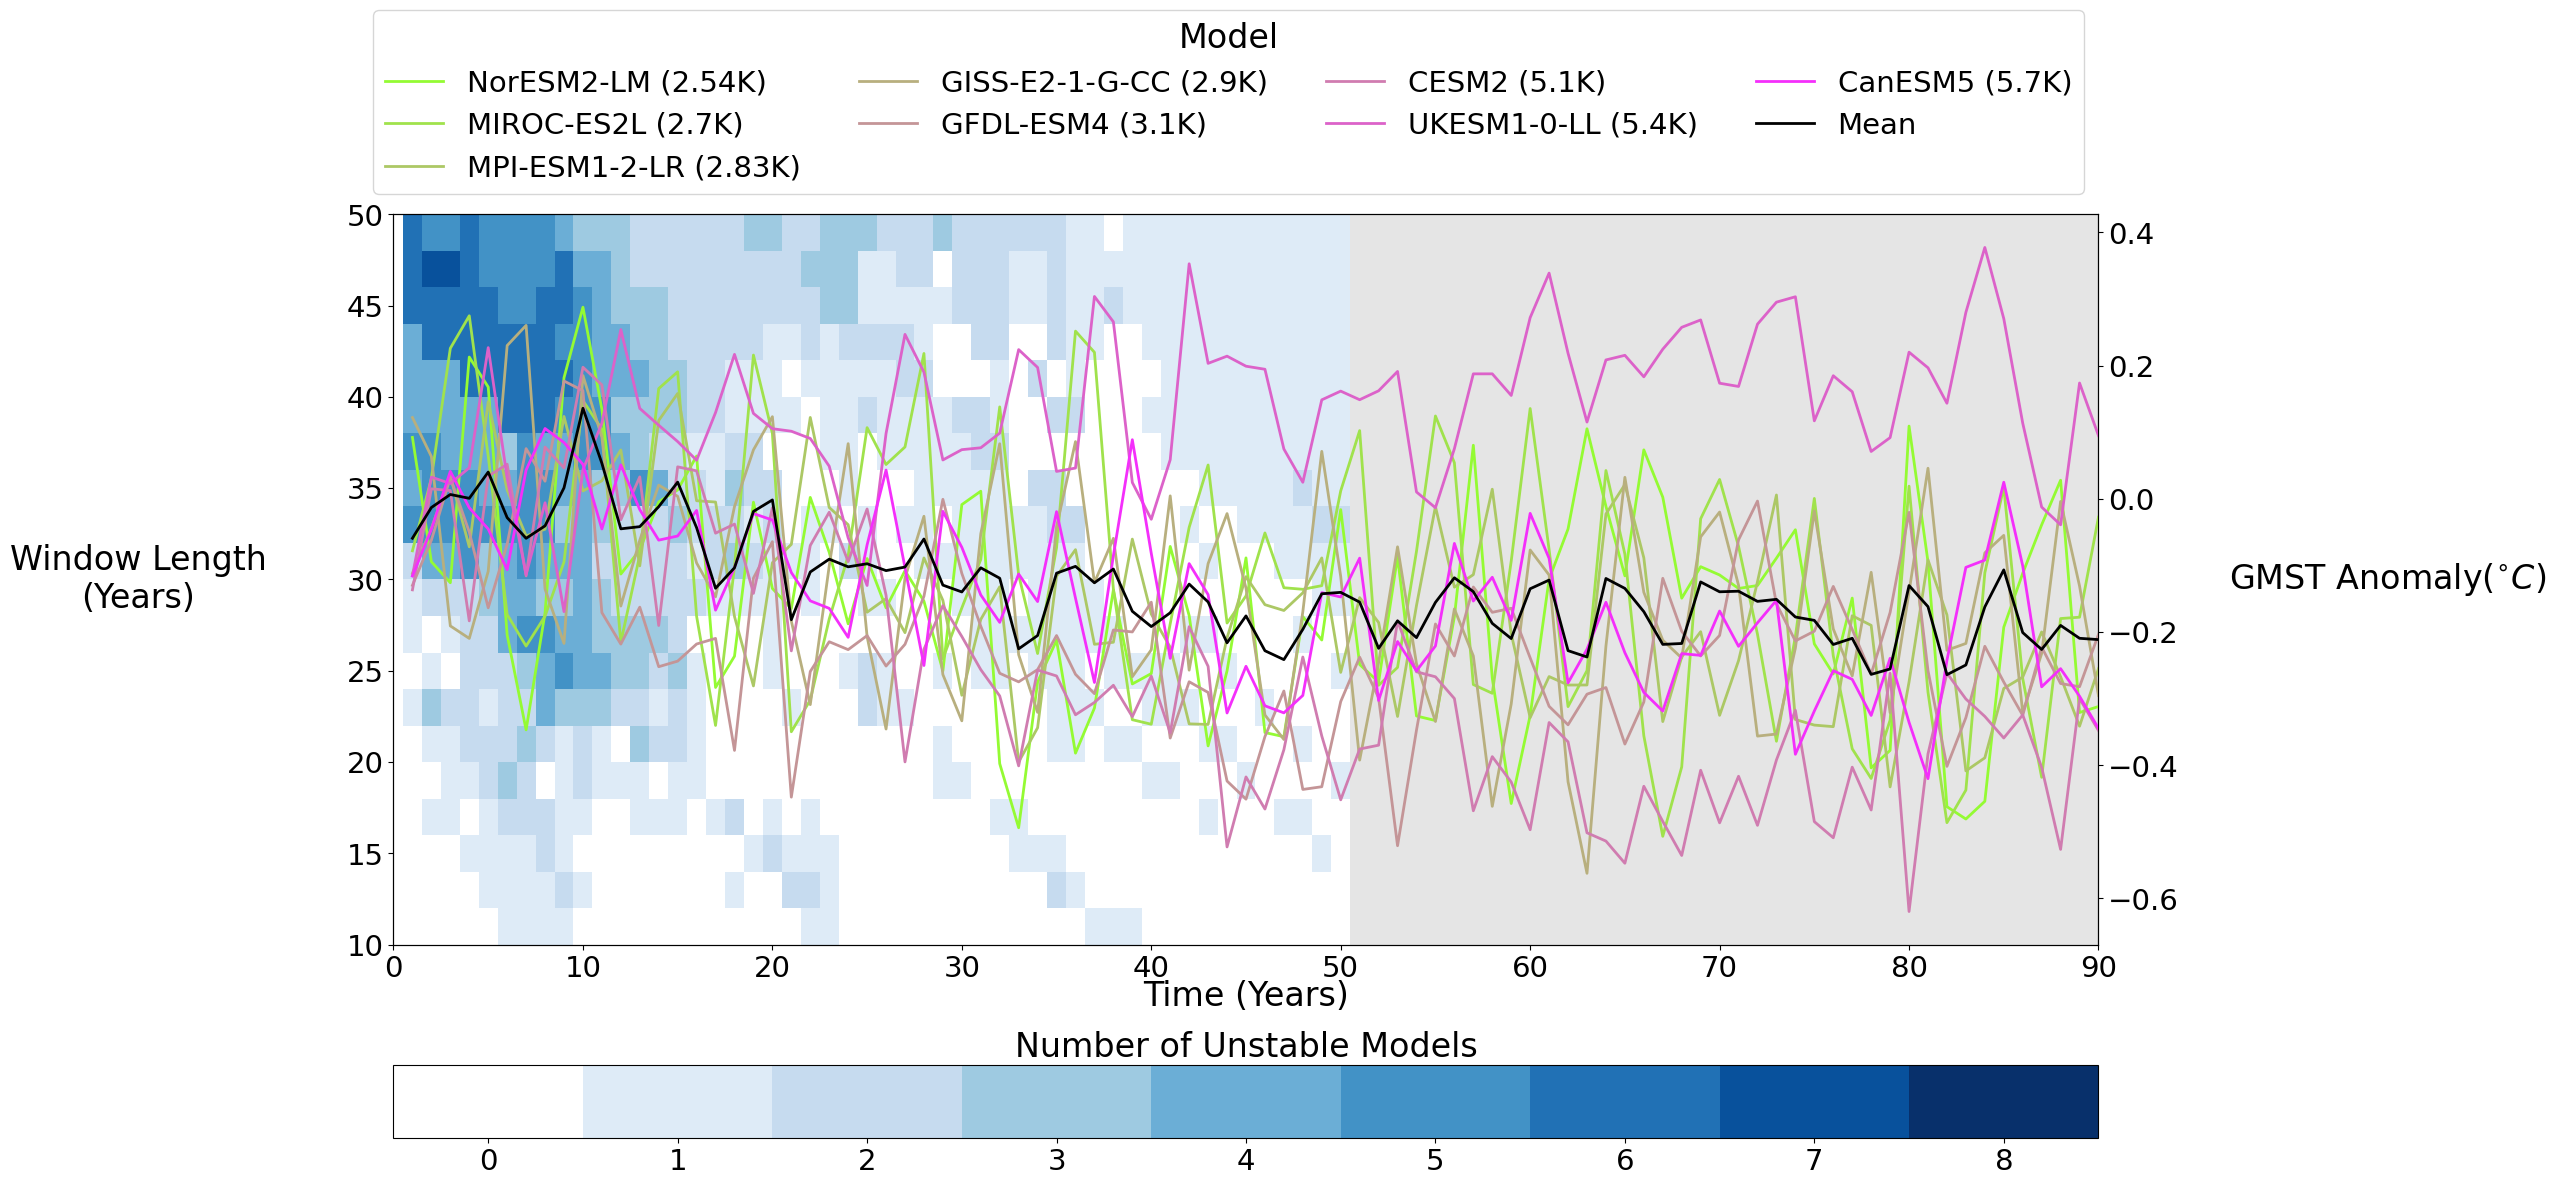

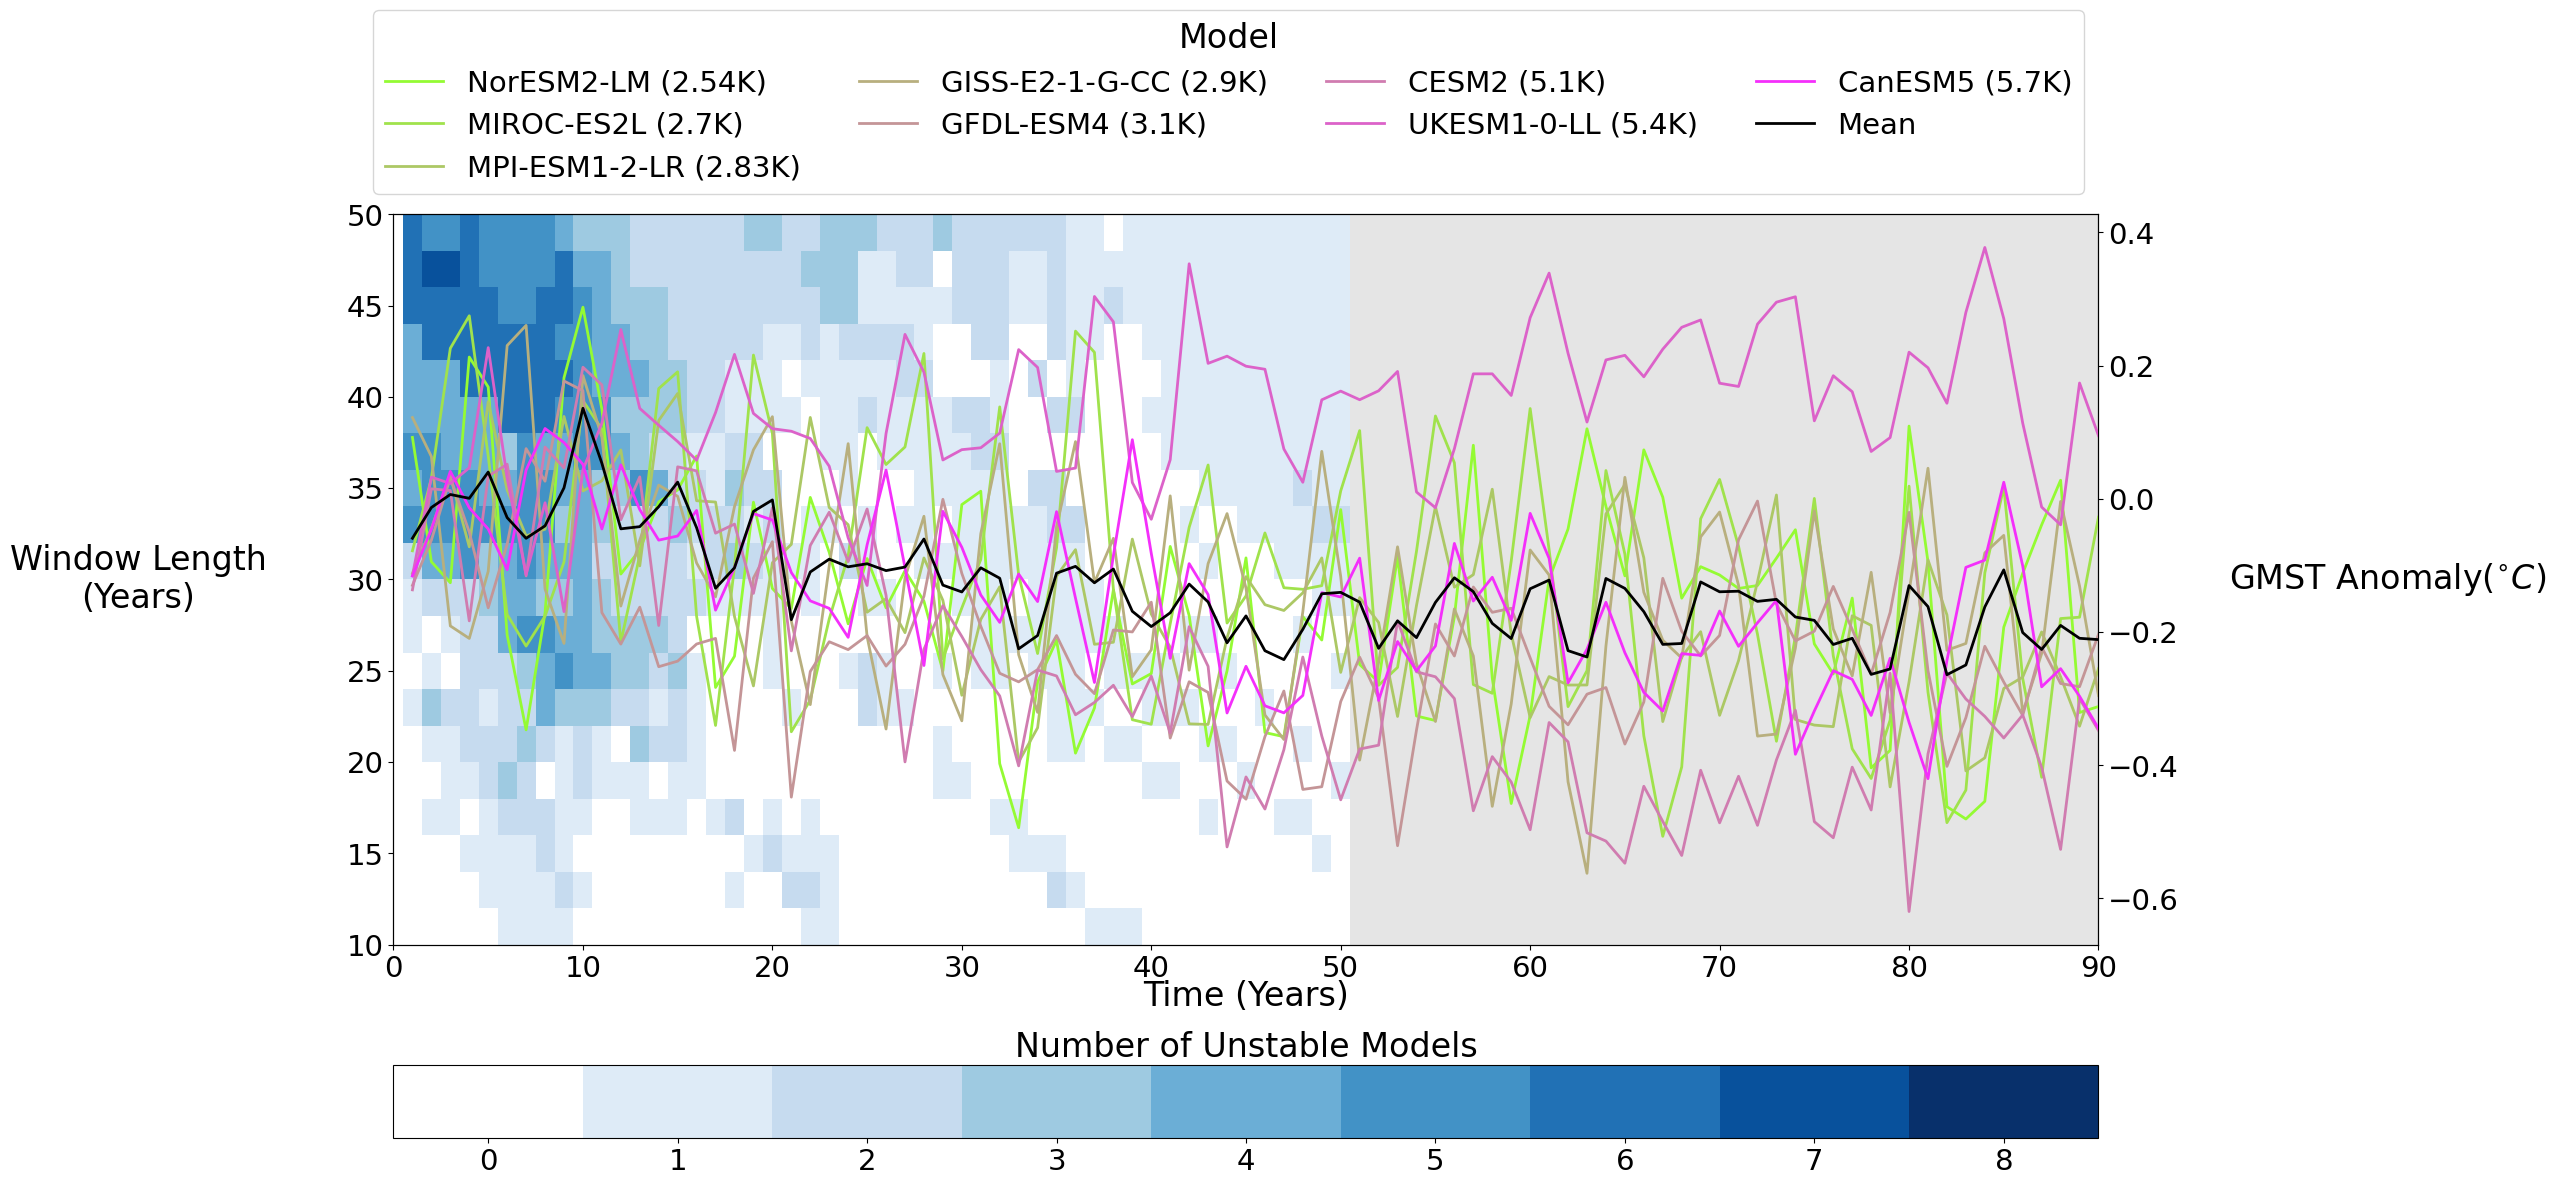

In [45]:
fig, axes = sn_plotting.sn_multi_window_in_time(
    static_stability_levels_ds.sel(stability='decreasing').count(dim='model'),
    temp_da=experiment_zec_ds_smean_anom, cmap=my_blues, **stability_colorplot_kwargs,  **plot_kwargs)

save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         f'{notebook_number}_global_average_stabilisation_pattern_cooling_static.png')
print(save_name)
fig.savefig(save_name, dpi=300, bbox_inches='tight')
fig

In [46]:
noise_levels = sn_plotting.create_levels(vmax=.13, vmin=0.1, step=.002)

In [47]:
%matplotlib inline

/home/563/ab2313/gdata/images/PhD/top_level/01_global_average_noise_rolling.png


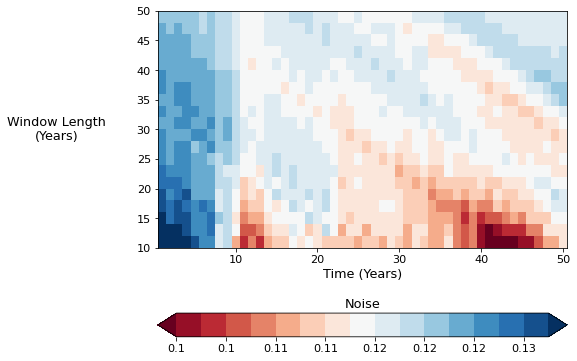

In [48]:
sn_plotting.plot_heatmap(sn_multi_rolling_ds.noise.mean(dim='model'), levels=noise_levels, 
                                figsize=(sn_plotting.plot_kwargs['width']/3,
                                         sn_plotting.plot_kwargs['height']/2), 
                               cmap='RdBu', extend='both', cut_ticks=2, max_color_lim=50, 
                               font_scale=0.8, cbar_label='Noise', hspace=0.2, return_all=False)

save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         f'{notebook_number}_global_average_noise_rolling.png')
print(save_name)
fig.savefig(save_name, dpi=300, bbox_inches='tight')

In [49]:
percent_frac = sn_multi_rolling_ds.noise*100/sn_multi_static_ds.noise
diff = sn_multi_rolling_ds.noise - sn_multi_static_ds.noise
percent_diff = diff * 100/sn_multi_rolling_ds.noise

In [50]:
# plot_kwargs_2 = dict(height=12, width=22, hspace=0.3, #vmin=-8, vmax=8, step=2, 
#                    cmap = 'RdBu_r', line_color = 'limegreen', line_alpha=0.65, 
#                    ax2_ylabel = 'Anomaly', cbar_label = 'Signal-to-Noise', cbartick_offset=0,
#                    axes_title='',
#                    title='', label_size=12, extend='both', xlowerlim=None, xupperlim=None,  filter_max=True,)